<div style="text-align:left; margin: 20px 0;">
  <img src="artwork/virtualbackground_langella.jpg" 
       alt="Seminario Estate GIS 2025 - Giuliano Langella" 
       style="max-width:50%; height:auto; border-radius:8px; box-shadow:0 2px 6px rgba(0,0,0,0.2);" />
</div>

# EuroSAT and deep learning

<p style="color:blue">Piano di lavoro per modello <b>custom</b> (from scratch) + setup esperimento replicabile.</p>

> Obiettivo: costruire **un modello di classificazione supervisionata** personalizzato (DL **from scratch**, non pre-addestrato) su un **subset bilanciato** del dataset **EuroSAT_MS** (10 classi), con split **train/val = 80/20** e **test esterno** separato. In una fase successiva, confronteremo le stesse partizioni con un **modello pre-addestrato** (transfer learning).

## Step 1 — Requisiti software (per Docker/requirements)

Per evitare conflitti e garantire la replicabilità dell’esperimento, fissiamo le versioni delle librerie principali. Questi pacchetti coprono lettura immagini, costruzione del modello, metriche e grafici.

- `numpy<2.0`  
- `tensorflow~=2.17`  *(CPU sufficiente; GPU opzionale)*  
- `scikit-learn<1.5`  
- `matplotlib<3.9`  
- `pandas>=2.2`  
- `pillow>=10.0`  *(per .jpg/.png)*  
- `tifffile>=2024.5.22`  *(per .tif multispettrali, senza dipendenze GDAL)*  
- `tqdm>=4.66`
- `rasterio<1.4`  *(richiede GDAL, ma l’immagine Jupyter ufficiale lo supporta senza problemi)*

> Nota: se in futuro useremo il download diretto da TFDS o Kaggle, potremo aggiungere rispettivamente `tensorflow-datasets` e/o `kaggle`.

### Bozza docker-compose

```yaml
services:
  jlab:
    image: jupyter/scipy-notebook:python-3.11
    ports:
      - "8888:8888"
    environment:
      - JUPYTER_TOKEN=estategis
      - LD_LIBRARY_PATH=/opt/conda/lib
    volumes:
      - ./supclassann:/home/jovyan/work
      - ./requirements.txt:/tmp/requirements.txt:ro
    command: >
      bash -lc "
      mamba install -y -c conda-forge sqlite=3.46.1 libsqlite=3.46.1 gdal=3.8 rasterio=1.3.10 &&
      pip install --no-cache-dir -r /tmp/requirements.txt &&
      start.sh jupyter lab --LabApp.token=estategis --LabApp.allow_origin='*'"
    restart: unless-stopped
```    

## Step 2 — Assunzioni e struttura dati

Per questo esperimento utilizziamo il dataset **EuroSAT_MS**, già scaricato e organizzato localmente con una cartella per ciascuna classe:
```BASH
  EuroSAT_MS/
    AnnualCrop/
    Forest/
    HerbaceousVegetation/
    Highway/
    Industrial/
    Pasture/
    PermanentCrop/
    Residential/
    River/
    SeaLake/
```

- Ogni sottocartella contiene le immagini relative a una singola classe.  
- Le immagini sono nativamente **64×64 pixel**:  
  - in versione **RGB** (3 canali) → file `.jpg` o `.png`  
  - oppure **multispettrale** (fino a 13 canali) → file `.tif` (<b style="color:blue">usate in questo esercizio</b>)
- Il notebook sarà eseguito **all’interno del container JupyterLab**.  
- Tutti i blocchi di codice Python forniti andranno eseguiti in sequenza nelle celle del notebook.  

**Nota:** <br>
Per garantire la riproducibilità, in seguito fisseremo un *seed* globale e genereremo liste di file (`train_list.csv`, `val_list.csv`, `test_list.csv`) da salvare e riutilizzare anche per i confronti con modelli pre-addestrati.


### Codice Python

#### Bande Sentinel 2 - caso studio multispettrale

<img src="artwork/Sen2_bands.png" alt="Sentinel-2 Bands" width="600">

In [113]:
SENTINEL2_BAND_NAMES = [
    "B01 (443 nm – Coastal aerosol)",
    "B02 (490 nm – Blue)",
    "B03 (560 nm – Green)",
    "B04 (665 nm – Red)",
    "B05 (705 nm – Red Edge 1)",
    "B06 (740 nm – Red Edge 2)",
    "B07 (783 nm – Red Edge 3)",
    "B08 (842 nm – NIR)",
    "B8A (865 nm – NIR narrow)",
    "B09 (945 nm – Water vapor)",
    "B10 (1375 nm – Cirrus)",
    "B11 (1610 nm – SWIR 1)",
    "B12 (2190 nm – SWIR 2)",
]

#### Dimensione del dataset e classi
Con questo step abbiamo:

- fissato il percorso ai dati (DATA_ROOT)
- contanto il numero di file .tif per ciascuna classe

In [114]:
import os

DATA_ROOT = "/home/jovyan/work/EuroSAT_MS"

In [115]:
os.listdir(DATA_ROOT)

['Forest',
 'River',
 'Highway',
 'AnnualCrop',
 'SeaLake',
 'HerbaceousVegetation',
 'Industrial',
 'Residential',
 'PermanentCrop',
 'Pasture']

In [116]:
total_files = 0
for folder in sorted(os.listdir(DATA_ROOT)):
    path = os.path.join(DATA_ROOT, folder)
    if os.path.isdir(path):
        # inizializza il contatore
        count = 0
        
        # scorri tutti i file nella cartella
        for f in os.listdir(path):
            file_path = os.path.join(path, f)

            # controlla che sia un file e che finisca con .tif
            if os.path.isfile(file_path) and f.lower().endswith(".tif"):
                count = count + 1   # aggiorna il contatore

        total_files += count
        print(f"{folder:<20} {count} files")
print(f"{'Totale':<20} {total_files} files")

AnnualCrop           3000 files
Forest               3000 files
HerbaceousVegetation 3000 files
Highway              2500 files
Industrial           2500 files
Pasture              2000 files
PermanentCrop        2500 files
Residential          3000 files
River                2500 files
SeaLake              3000 files
Totale               27000 files


#### Esame di un file tif per una classe

In [117]:
import os
import random
from glob import glob

import numpy as np
import rasterio
import matplotlib.pyplot as plt

DATA_ROOT = "/home/jovyan/work/EuroSAT_MS"
extensions = (".tif", ".tiff")

#### 1) Raccoglie tutti i GeoTIFF dalle cartelle delle classi e ne sceglie uno a caso

In [118]:
all_files = []
for cls in os.listdir(DATA_ROOT):
  p = os.path.join(DATA_ROOT, cls)
  if os.path.isdir(p):
    all_files.extend([f for f in glob(os.path.join(p, "*")) if f.lower().endswith(extensions)])

if not all_files:
  raise RuntimeError("No GeoTIFFs found under EuroSAT_MS/*")

tif_path = random.choice(all_files)
print(f"Selected file: {tif_path}")

Selected file: /home/jovyan/work/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_623.tif


#### 2) Legge e stampa i metadati ed altre info
**inserire come titolo nei subplot il nome della banda**


--- Metadata ---
CRS:            EPSG:32630
Transform:      | 10.00, 0.00, 574792.64|
| 0.00,-9.99, 5917068.95|
| 0.00, 0.00, 1.00|
Width x Height: 64 x 64 px
Bands (count):  13
Dtype:          ('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')
Nodata:         None
Image size:     104.00 KB


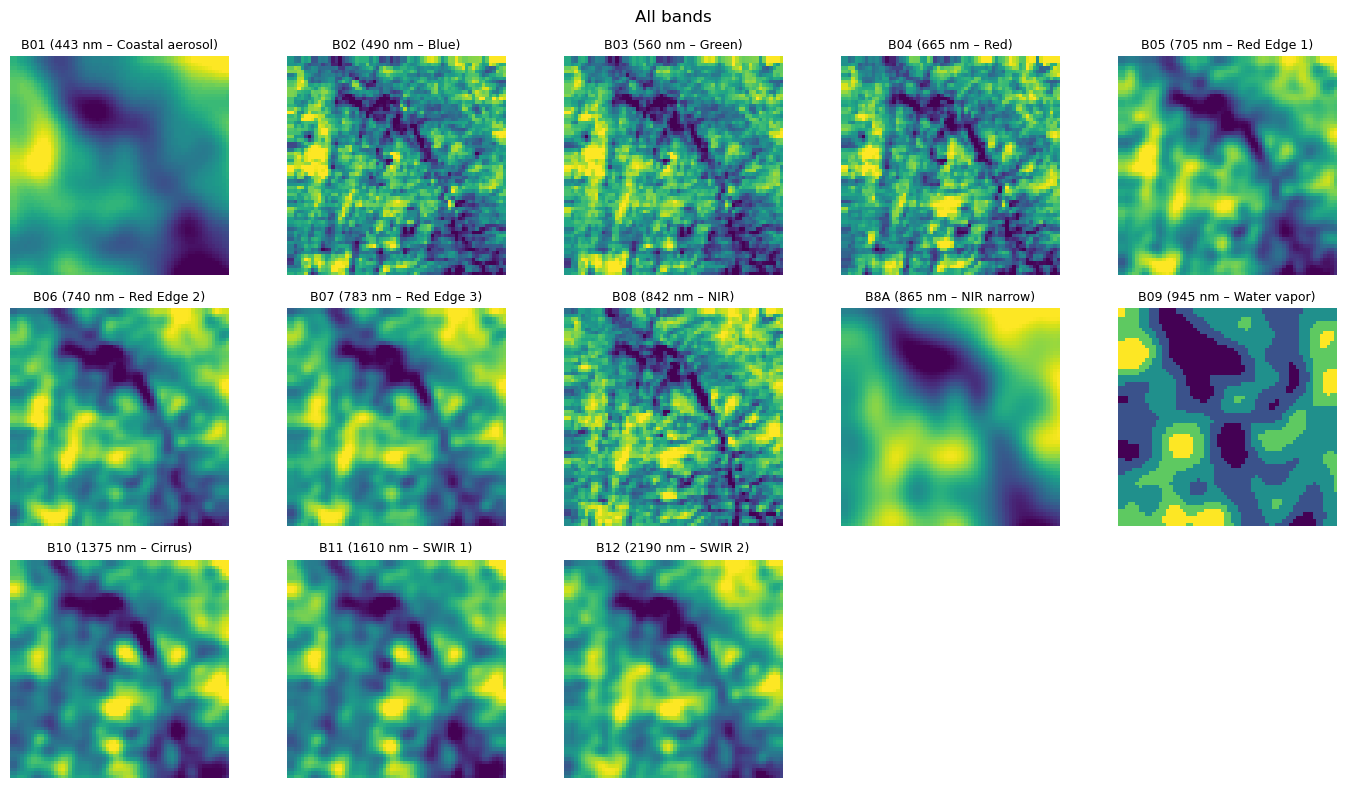

In [119]:
with rasterio.open(tif_path) as ds:
  # Basic metadata
  print("\n--- Metadata ---")
  print(f"CRS:            {ds.crs}")           # Coordinate Reference System
  print(f"Transform:      {ds.transform}")     # Affine geotransform
  print(f"Width x Height: {ds.width} x {ds.height} px")
  print(f"Bands (count):  {ds.count}")
  print(f"Dtype:          {ds.dtypes}")        # list per band
  print(f'Nodata:         {ds.nodata}')
  image_size_bytes = ds.width * ds.height * ds.count * np.dtype(ds.dtypes[0]).itemsize
  print(f"Image size:     {image_size_bytes/1024:.2f} KB")

  # 3) Plot all bands (assume 13 bands) with a simple percentile stretch
  bands_to_plot = ds.count
  # Create a grid (3x5 fits 13 bands -> 2 empty)
  rows, cols = 3, 5
  fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
  axes = axes.ravel()

  for b in range(1, bands_to_plot + 1):
    ax = axes[b-1]
    # Read as masked array for nodata
    band = ds.read(b, masked=True)

    # Percentile stretch for better contrast
    # (robust to outliers; adjust p_low/p_high if needed)
    p_low, p_high = np.percentile(band.compressed(), [2, 98]) if band.mask is not np.ma.nomask else np.percentile(band, [2, 98])

    im = ax.imshow(band, vmin=p_low, vmax=p_high)
    bands_to_plot = min(ds.count, len(SENTINEL2_BAND_NAMES))
    ax.set_title(SENTINEL2_BAND_NAMES[b-1], fontsize=9)
    #ax.set_title(f"Band {b}", fontsize=9)
    ax.axis("off")

  # Hide any unused axes (if bands < rows*cols)
  for k in range(bands_to_plot, rows*cols):
    axes[k].axis("off")

  fig.suptitle("All bands", fontsize=12)
  fig.tight_layout()
  plt.show()

## Step 3 — Working directory e seed

In questa fase impostiamo la **working directory** e fissiamo un **seed globale** per garantire la replicabilità dell’esperimento. Tutte le operazioni di selezione casuale dei file, split train/val/test e inizializzazione del modello saranno determinate dallo stesso seed, così ogni partecipante otterrà esattamente lo stesso subset e gli stessi risultati di training (entro la variabilità residua di TensorFlow).

### Codice Python

#### Seed & classi
Con questo step abbiamo fissato:

- il percorso ai dati (DATA_ROOT)
- il seed globale (SEED)
- la lista delle classi disponibili nel dataset (verificata a runtime)

In [120]:
import os, random
import numpy as np
import tensorflow as tf

# Working directory: cartella dove si trovano i dati EuroSAT_MS
DATA_ROOT = "/home/jovyan/work/EuroSAT_MS"

In [121]:
# Seed globale
SEED = 3008

# Impostazione seed per Python, NumPy e TensorFlow
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

##### Capire il seed:

In [122]:
np.random.seed(SEED)
print(np.random.rand())  # → sempre lo stesso numero se esegui dall'inizio
print(np.random.rand())  # → numero successivo nella sequenza

0.9121940999636362
0.4658006204694346


In [123]:
np.random.seed(SEED)
print(np.random.rand())  # → sempre lo stesso numero se esegui dall'inizio
np.random.seed(SEED)
print(np.random.rand())  # → numero successivo nella sequenza

0.9121940999636362
0.9121940999636362


##### Controllo che la cartella esista e stampa delle classi disponibili

In [124]:
if not os.path.isdir(DATA_ROOT):
    raise FileNotFoundError(f"La directory {DATA_ROOT} non esiste. Verifica il percorso.")
    
classes = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
print(f"Trovate {len(classes)} classi: {classes}")

Trovate 10 classi: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Step 4 — Esplorazione rapida: campioni per classe

### Obiettivo

Prima di costruire il subset, verifichiamo che le immagini siano correttamente leggibili e che la mappa **classe → cartella** sia coerente.  
Per ciascuna classe selezioniamo **2 immagini a caso** con il seed fissato e le mostriamo in una griglia.  
Se le immagini hanno più di 3 canali (multispettrali), per la visualizzazione utilizziamo i canali RGB.

### Codice Python

In [125]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tifffile

#### Assunzioni:
 - DATA_ROOT e classes sono già definiti nello Step 3
 - Ogni immagine TIF ha shape (H, W, 13) con ordine bande:<br>
   [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]<br>
   -> RGB = [B04,B03,B02] = indici [3,2,1] (0-based)

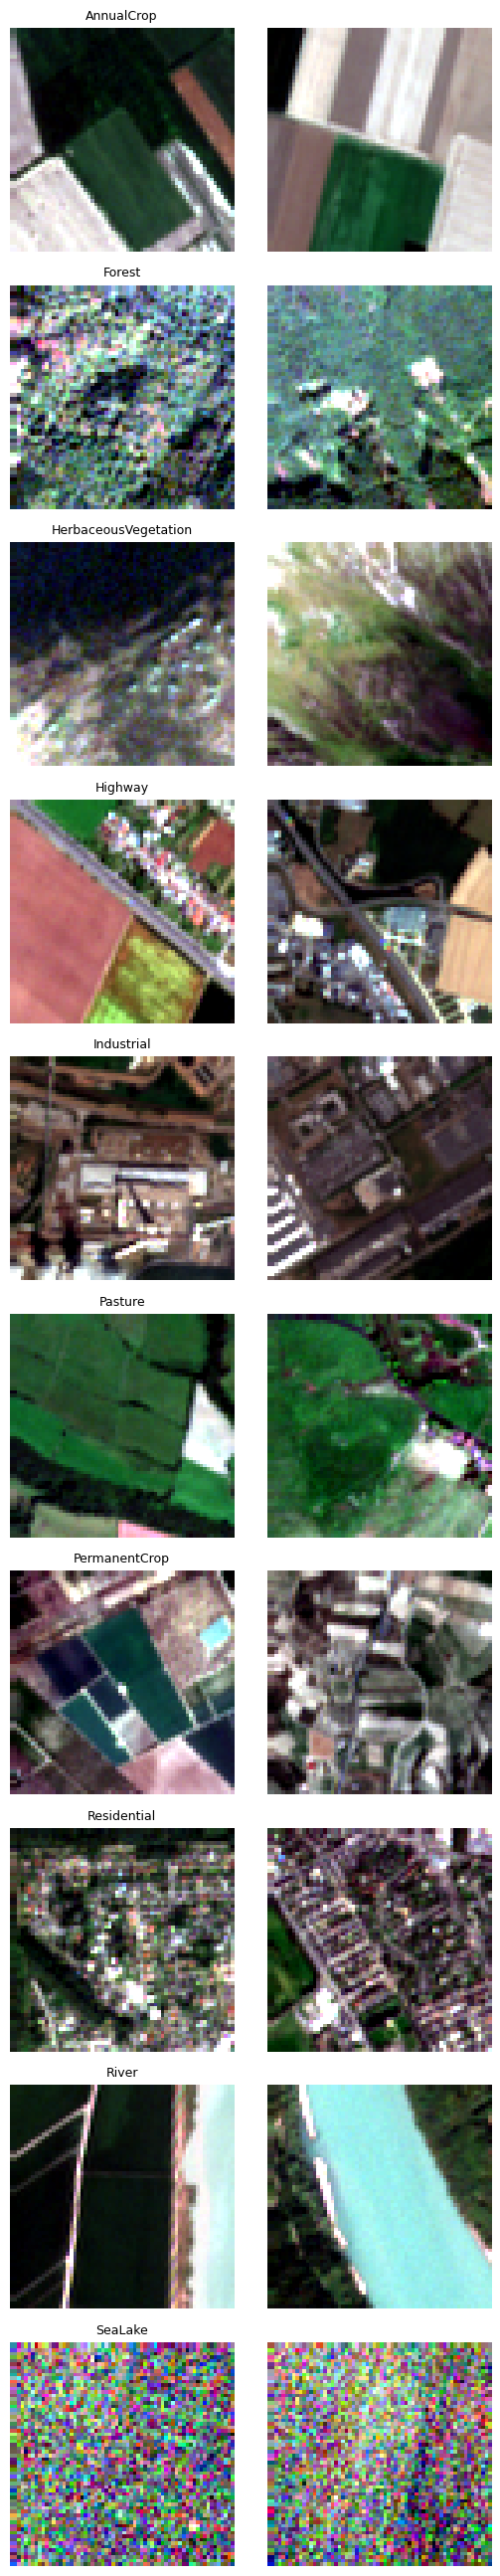

In [126]:
RGB_IDX = [3, 2, 1]   # B4, B3, B2
N_SAMPLES = 2         # immagini da mostrare per classe

random.seed(SEED)

def to_uint8_rgb(x, eps=1e-6):
    """
    x: array (H,W,3) float/uint con dinamica ignota.
    1) percentili per banda (p2,p98), 2) clip, 3) normalizza 0..1, 4) uint8.
    """
    x = x.astype(np.float32)
    out = np.zeros_like(x, dtype=np.float32)
    for c in range(3):
        lo, hi = np.percentile(x[..., c], [2, 98])
        if hi - lo < eps:  # evita divisioni per zero su bande piatte
            out[..., c] = 0.0
        else:
            out[..., c] = np.clip((x[..., c] - lo) / (hi - lo), 0.0, 1.0)
    return (out * 255.0).astype(np.uint8)

# Costruiamo la griglia: ogni riga = una classe, 2 colonne = 2 campioni
fig, axes = plt.subplots(len(classes), 
                         N_SAMPLES, 
                         figsize=(2.8*N_SAMPLES, 2.6*len(classes)))

if len(classes) == 1:
    axes = np.array([axes])  # compatibilità quando c'è una sola classe

for i, cls in enumerate(classes):
    cls_dir = os.path.join(DATA_ROOT, cls)
    # prendi solo i .tif
    tif_files = sorted([f for f in os.listdir(cls_dir) if f.lower().endswith(".tif")])
    if len(tif_files) < N_SAMPLES:
        raise RuntimeError(f"Classe '{cls}' ha solo {len(tif_files)} tif: aumenta N_SAMPLES o verifica i dati.")

    # selezione deterministica con seed globale
    samples = random.sample(tif_files, N_SAMPLES)

    for j, fname in enumerate(samples):
        path = os.path.join(cls_dir, fname)
        arr = tifffile.imread(path)              # atteso (H,W,13)
        if arr.ndim != 3 or arr.shape[-1] < 13:
            raise ValueError(f"Formato inatteso per {path}: shape={arr.shape}, atteso (H,W,13).")

        rgb = arr[..., RGB_IDX]                  # (H,W,3) = B4,B3,B2
        rgb8 = to_uint8_rgb(rgb)                 # normalizza + uint8

        ax = axes[i, j] if len(classes) > 1 else axes[0, j]
        ax.imshow(rgb8)
        ax.set_axis_off()
        if j == 0:
            ax.set_title(cls, fontsize=9)

plt.tight_layout()
plt.show()

## Step 5 — Selezione del subset bilanciato

In questo step costruiamo un **subset bilanciato** del dataset, con la stessa quantità di immagini per ciascuna delle 10 classi.  
Per ogni classe estraiamo un numero prefissato di immagini, poi le dividiamo in **train (80%)**, **val (20%)** e **test esterno**.  
L’uso di un **seed fisso** assicura che tutti ottengano lo stesso split.

### Codice Python

#### Dimensionamento del dataset

In [127]:
import os, random, csv
import numpy as np

Parametri per il subset:

In [128]:
N_TRAINVAL_PER_CLASS = 500    # immagini per classe destinate a train+val
N_TEST_PER_CLASS     = 200    # immagini per classe destinate a test esterno
TRAIN_RATIO          = 0.8    # percentuale di dati da usare per il training (vs val)

train_list, val_list, test_list = [], [], []

Cartella dove salvare le liste dei file:

In [129]:
SPLIT_DIR = "./split_lists"
os.makedirs(SPLIT_DIR, exist_ok=True)

Assumiamo "classes" e "DATA_ROOT" definiti nello step 3.<br>
Per massima stabilità, ordiniamo le classi alfabeticamente.

In [130]:
classes_sorted = sorted(classes)

for cls in classes_sorted:
    cls_dir = os.path.join(DATA_ROOT, cls)
    # Prendi SOLO i tif e ordina alfabeticamente (stabilità)
    files = sorted([f for f in os.listdir(cls_dir) if f.lower().endswith(".tif")])

    # Generatore RNG LOCALE per questa classe, indipendente dal globale:
    # seed derivato da SEED e dal nome classe -> split identico a ogni run
    rng = random.Random(f"{SEED}-{cls}")

    # Mescoliamo la copia della lista `files` con il RNG locale, così da non alterare lo stato globale.
    files_shuffled = files[:]   # copia
    rng.shuffle(files_shuffled)

    # Selezione immagini per train+val e test
    needed = N_TRAINVAL_PER_CLASS + N_TEST_PER_CLASS
    if len(files_shuffled) < needed:
        raise RuntimeError(
            f"Classe '{cls}': servono {needed} immagini, trovate {len(files_shuffled)}."
        )

    # SLICING:
    selected       = files_shuffled[:needed]
    trainval_files = selected[:N_TRAINVAL_PER_CLASS]
    test_files     = selected[N_TRAINVAL_PER_CLASS:]

    # Split su train/val
    n_train     = int(N_TRAINVAL_PER_CLASS * TRAIN_RATIO)
    train_files = trainval_files[:n_train]
    val_files   = trainval_files[n_train:]

    # Accumula con percorsi assoluti + label
    for f in train_files:
        train_list.append((os.path.join(cls_dir, f), cls))
    for f in val_files:
        val_list.append((os.path.join(cls_dir, f), cls))
    for f in test_files:
        test_list.append((os.path.join(cls_dir, f), cls))

#### Salva la ripartizione nei subset

Utility per salvare CSV con header fisso:

In [131]:
def save_list(filename, data):
    with open(os.path.join(SPLIT_DIR, filename), "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filepath", "label"])
        writer.writerows(data)

Salvataggio:

In [132]:
save_list("train_list.csv", train_list)
save_list("val_list.csv",   val_list)
save_list("test_list.csv",  test_list)

Riepilogo:

In [133]:
print(f"Train: {len(train_list)}  | Val: {len(val_list)}  | Test: {len(test_list)}")
print(f"CSV salvati in: {os.path.abspath(SPLIT_DIR)}")

Train: 4000  | Val: 1000  | Test: 2000
CSV salvati in: /home/jovyan/work/split_lists


#### Spiegazione dello slicing in Python

In Python la forma generale dello slicing è:
```python
lista[start:stop]
```

- **Inclusivo su `start`**, **esclusivo su `stop`**  
  → `lista[2:5]` prende gli elementi con indici `2, 3, 4` (ma non `5`).  
- Se `start` è omesso (`:stop`), l’estrazione parte dall’inizio della lista.  
- Se `stop` è omesso (`start:`), l’estrazione continua fino alla fine della lista.  

Nel nostro caso:

```python
trainval_files = selected[:N_TRAINVAL_PER_CLASS]
test_files = selected[N_TRAINVAL_PER_CLASS:]
```

- selected[:N_TRAINVAL_PER_CLASS] prende i primi N_TRAINVAL_PER_CLASS elementi (indici da 0 a N_TRAINVAL_PER_CLASS-1).
- selected[N_TRAINVAL_PER_CLASS:] prende dal successivo (N_TRAINVAL_PER_CLASS) fino all’ultimo elemento della lista.

Qui `f"{SEED}-{cls}"` è una stringa, ad esempio "42-AnnualCrop" ed il costruttore random.Random(...) accetta qualsiasi tipo “hashabile” come seed: non solo numeri, ma anche stringhe!

In [134]:
print(f"{SEED}-{cls}")
print(hash(f"{SEED}-{cls}"))

3008-SeaLake
25251982982676550


## Step 6 — Preprocessing

In questo step definiamo **come trasformare** i file GeoTIFF multispettrali (shape attesa: `64×64×13`) in tensori pronti per il modello.

**Obiettivi:**
1. **Caricare** i TIF multispettrali (13 bande) come array `uint16`.
2. **Stimare** media $\mu_b$ e deviazione standard $\sigma_b$ **per banda** sul **solo train** (tutti i pixel, tutte le immagini train).
3. **Normalizzare per banda**: per ogni banda $b$, applicare

$\displaystyle x'_{b} \;=\; \frac{x_{b} - \mu_b}{\sigma_b} $
   
4. Rendere queste trasformazioni **riutilizzabili** su train/val/test in modo coerente.

#### Stima statistiche — Media e varianza per banda sul SOLO train

**Idea chiave:**  
- Calcolare $\mu_b$ e $\sigma_b$ **usando tutte le immagini e tutti i pixel del train**; così le statistiche descrivono il dominio visto dal modello in apprendimento e **non contaminano** val/test (niente leakage).<br>
<i style="color:orange"><b>Leakage:</b> quando informazioni dei dati di validazione o test finiscono, anche indirettamente, dentro il training, falsando i risultati</i>

**Come lo facciamo:**  
- Per ogni immagine `img ∈ ℝ^{64×64×13}`, sommiamo lungo gli assi spaziali `(0,1)`:
  - `img.sum(axis=(0,1))` → vettore **(13,)** = **somma per banda** su tutti i pixel della patch.  
  - `(img * img).sum(axis=(0,1))` → vettore **(13,)** = **somma dei quadrati** per banda.
- Accumuliamo **somme** e **somme dei quadrati** su tutte le immagini train:
  - $\text{sum}_b = \sum_{i=1}^{N} \sum_{p} x_{i,p,b}$
  - $\text{sumsq}_b = \sum_{i=1}^{N} \sum_{p} x^2_{i,p,b}$
  - $N_{\text{pix}}$ = numero totale di pixel aggregati (immagini × $64×64$).

**Formule (teoriche) applicate:**

$\displaystyle \mu_b = \frac{1}{N_{\text{pix}}}\sum_{i,p} x_{i,p,b}$

$\displaystyle \operatorname{Var}(X_b) = \mathbb{E}[X_b^2] - \big(\mathbb{E}[X_b]\big)^2 = \frac{1}{N_{\text{pix}}}\sum_{i,p} x_{i,p,b}^2 - \mu_b^2$

$\displaystyle \sigma_b = \sqrt{\max\big(\operatorname{Var}(X_b), \; \varepsilon\big)} $

dove $\varepsilon$ è un piccolo termine di stabilità numerica (es. $10^{-12}$) per evitare divisioni per zero.

**Perché usare somme e somme dei quadrati:**  
- Permette di calcolare media/varianza **senza caricare tutto in RAM**: elaboriamo immagine per immagine (streaming), accumulando statistiche.

### Codice Python

In [135]:
import os
import numpy as np
import tifffile

 Assunzioni già definite negli step precedenti
 
 - train_list, val_list, test_list: liste di tuple (filepath, label)
 - Ogni filepath punta a un TIF di shape (64, 64, 13)

#### 1) Funzione `load_ms_13(path)` — Caricamento TIF multispettrale (13 bande)

**Cosa fa:**  
- Legge da disco un file TIF multispettrale e lo restituisce come array `float32` di shape **(64, 64, 13)**.  
- Verifica che la shape sia proprio a **13 bande**; in caso contrario, solleva un errore esplicito (utile per individuare subito anomalie di formato).

**Perché serve:**  
- Separiamo la responsabilità di **I/O** da quella della **normalizzazione**: la funzione è “atomica” e la riutilizzemo dopo.

In [136]:
def load_ms_13(path):
    arr = tifffile.imread(path).astype(np.float32)         # (64,64,13)
    if arr.ndim != 3 or arr.shape[-1] != 13:
        raise ValueError(f"Atteso (H,W,13), ottenuto {arr.shape} per {path}")
    return arr

#### 2) Funzione `normalize_ms_13(arr, mean13, std13)` — Standardizzazione per-banda

**Cosa fa:**  
- Riceve un tensore **(64, 64, 13)** e due vettori **(13,)** `mean13` e `std13`.  
- Applica la **standardizzazione per-banda** con broadcasting:
  $$
  x'(\cdot,\cdot,b) = \frac{x(\cdot,\cdot,b) - \mu_b}{\sigma_b}.
  $$

**Perché serve:**  
- Le bande hanno **scale diverse** (dinamiche differenti): standardizzare per banda aiuta l’ottimizzazione (gradiente più stabile) e riduce bias di scala (??).

In [137]:
def normalize_ms_13(arr, mean_per_band, std_per_band):
    return (arr - mean_per_band[None, None, :]) / std_per_band[None, None, :]

#### 3) Funzione `preprocess_ms_13(path, mean13, std13)` — Pipeline per un singolo file

**Cosa fa:**  
- Combina **caricamento** + **normalizzazione** in un’unica funzione:
  1. `load_ms_13(path)` → array **(64,64,13)** in `float32`.
  2. `normalize_ms_13(arr, ...)` → array **(64,64,13)** normalizzato per banda.

**Perché serve:**  
- È la funzione “pronta all’uso” per costruire i dataset di **train/val/test** in modo coerente, passando esplicitamente **le statistiche calcolate sul train**.

In [138]:
def preprocess_ms_13(path, mean_per_band, std_per_band):
    arr = load_ms_13(path)
    arr_norm = normalize_ms_13(arr, mean_per_band, std_per_band)
    return arr_norm

#### 4) Main code
Stima mean/std GLOBALI per-banda sul SOLO train (tutti i pixel di tutte le immagini train)<br>
Evitiamo di caricare tutto in RAM: accumuliamo somme e somme dei quadrati per banda.

In [139]:
sum_per_band   = np.zeros(13, dtype=np.float64)
sumsq_per_band = np.zeros(13, dtype=np.float64)
n_pixels_total = 0

In [140]:
for fp, _ in train_list:
    img = load_ms_13(fp)                                   # (64,64,13)
    # Somme per banda su tutti i pixel della patch
    sum_per_band   += img.sum(axis=(0, 1))                 # shape (13,)
    sumsq_per_band += (img * img).sum(axis=(0, 1))         # shape (13,)
    n_pixels_total += img.shape[0] * img.shape[1]          # 64*64

In [141]:
print("Sum per banda (13):",sum_per_band)

Sum per banda (13): [2.22537131e+10 1.83456988e+10 1.71302942e+10 1.54671204e+10
 1.97740161e+10 3.34618360e+10 3.97127181e+10 3.84953179e+10
 1.22090323e+10 1.99618303e+08 3.01556939e+10 1.84249460e+10
 4.35071742e+10]


In [142]:
# Media e varianza per banda (formula: E[X^2] - (E[X])^2)
mean_per_band = (sum_per_band / n_pixels_total).astype(np.float32)              # (13,)
var_per_band  = (sumsq_per_band / n_pixels_total) - (mean_per_band.astype(np.float64)**2)
std_per_band  = np.sqrt(np.maximum(var_per_band, 1e-12)).astype(np.float32)     # (13,)

print("Mean per banda (13):", mean_per_band)
print("Std  per banda (13):", std_per_band)

Mean per banda (13): [1358.2589   1119.7325   1045.5502    944.0381   1206.9102   2042.3484
 2423.872    2349.5676    745.1802     12.183734 1840.5575   1124.5695
 2655.4673  ]
Std  per banda (13): [ 254.48128    339.29654    397.64938    593.9434     560.67346
  859.1143    1087.4064    1118.9155     407.649        4.5436354
  979.79865    748.1516    1230.1182   ]


#### 5) Verifica rapida su poche immagini per controllare shape e range

**Cosa controllare dopo aver calcolato $\mu_b$ e $\sigma_b$:**
- Che la **shape** dei tensori normalizzati sia `(64,64,13)`.  
- Che le statistiche grossolane **post-normalizzazione** su un piccolo campione siano sensate (es. media globale intorno a 0, std ≈ 1; non è un vincolo rigido, ma un’indicazione).

**Buone pratiche:**
- Stampare nome file, shape, media e std **dell’intero tensore** come sanity check.  
- Evitare di usare **val/test** per stimare statistiche: introdurrebbe **leakage**.

In [143]:
for fp, _ in (train_list[:2] + val_list[:1] + test_list[:1]):
    x = preprocess_ms_13(fp, mean_per_band, std_per_band) # (64,64,13), float32 normalizzato
    print(os.path.basename(fp), x.shape, f"mean≈{x.mean():.3f}", f"std≈{x.std():.3f}")

AnnualCrop_2637.tif (64, 64, 13) mean≈0.400 std≈0.810
AnnualCrop_1540.tif (64, 64, 13) mean≈0.328 std≈0.995
AnnualCrop_4.tif (64, 64, 13) mean≈1.588 std≈0.895
AnnualCrop_2724.tif (64, 64, 13) mean≈0.509 std≈0.652


### Note

#### `tifffile` vs `rasterio`: perché qui usiamo `tifffile`

- **`tifffile`**: libreria snella, veloce, perfetta quando servono **solo i pixel**; zero dipendenze da GDAL.  
- **`rasterio`**: ideale se servono **CRS, trasformazioni affini, bounding box**, operazioni GIS e gestione robusta dei metadati geospaziali.  

**In questo hands-on**: addestriamo un modello su **patch 64×64** senza usare coordinate o georeferenziazione → `tifffile` è più semplice

#### Riproducibilità e sicurezza del flusso

- Le statistiche $(\mu_b \,,\, \sigma_b)$ sono **calcolate una volta** sul **solo train** e poi **riutilizzate** identiche su val/test.  
- Le funzioni restano **pure** e indipendenti: non fanno riferimento a variabili globali.  
- In caso di dubbi o varianti (es. normalizzazione 0–1 invece dello standard score), si possono **documentare** facilmente le differenze sostituendo o aggiungendo il blocco di normalizzazione.

#### Leakage
Per *leakage* si intende una forma di **contaminazione dei dati di valutazione** con informazioni che provengono dal train.  
Esempio: se calcolassimo media e std usando anche immagini di validation o test, in pratica staremmo “informando” il preprocessing di statistiche che il modello non dovrebbe conoscere.  
Risultato: le metriche di valutazione sarebbero **troppo ottimistiche** e non rifletterebbero la performance reale su dati nuovi.

### Riepilogo

- **Perché normalizziamo?** Perché le bande hanno dinamiche diverse; standardizzare aiuta l’ottimizzatore e rende il problema numericamente più stabile.  
- **Perché solo train?** Per non “sbirciare” i dati di validazione/test: la valutazione deve riflettere condizioni reali su dati “nuovi”.  
- **Cosa aspettarsi dopo la normalizzazione?** Valori centrati intorno a 0 (per banda), con varianza di circa 1; non è perfetto su ogni immagine, ma è coerente a livello di distribuzione.

## Step 7 — Pipeline dati con `tf.data`

Per addestrare il modello è utile trasformare le liste di file (train/val/test) in pipeline efficienti con TensorFlow.

![tf_keras](artwork/keras_and_tf.png)

### Cos’è TensorFlow?

<div style="font-size:12px">

<b style="color:blue">TensorFlow</b> è una **piattaforma** di machine learning gratuita e open source, basata su Python, sviluppata principalmente da Google. Analogamente a NumPy, lo scopo principale di TensorFlow è consentire a ingegneri e ricercatori di manipolare espressioni matematiche su tensori numerici. Ma TensorFlow va ben oltre l’ambito di NumPy nei seguenti modi:

- Può calcolare automaticamente il gradiente di qualsiasi espressione differenziabile, il che lo rende altamente adatto al machine learning.  
- Può essere eseguito non solo su CPU, ma anche su GPU e TPU, acceleratori hardware altamente paralleli.  
- Le computazioni definite in TensorFlow possono essere facilmente distribuite su molte macchine.  
- I programmi TensorFlow possono essere esportati verso altri ambienti di esecuzione, come C++, JavaScript (per applicazioni basate su browser), o TFLite (per applicazioni che girano su dispositivi mobili o embedded). Questo rende le applicazioni TensorFlow facilmente distribuibili in contesti pratici.  

È importante tenere a mente che TensorFlow è molto più di una singola libreria: è davvero una <b style="color:blue">piattaforma</b>, sede di un vasto ecosistema di componenti, alcuni sviluppati da Google, altri da terze parti. Ad esempio, esiste TF-Agents per la ricerca in reinforcement learning, TFX per la gestione di workflow di machine learning a livello industriale, TF-Serving per il deployment in produzione, e il repository TF-Hub di modelli pre-addestrati. Insieme, questi componenti coprono una gamma molto ampia di casi d’uso, dalla ricerca più avanzata fino alle applicazioni di produzione su larga scala.  

TensorFlow è in grado di **scalare** piuttosto bene: per esempio, scienziati dell’Oak Ridge National Lab lo hanno utilizzato per addestrare un modello di previsione meteorologica estrema da 1.1 ExaFLOP sul supercomputer IBM Summit, dotato di 27.000 GPU. Allo stesso modo, Google ha usato TensorFlow per sviluppare applicazioni di deep learning estremamente compute-intensive, come l’agente AlphaZero per gli scacchi e il Go. Per i tuoi modelli, se hai il budget, puoi realisticamente sperare di scalare fino a circa 10 PetaFLOP su un piccolo TPU Pod o su un grande cluster di GPU a noleggio su Google Cloud o AWS. Sarebbe comunque circa l’1% della potenza di calcolo di picco del miglior supercomputer del 2019!

<sub>
<span style="font-size:10px">
François Chollet, <i>Deep Learning with Python</i>, Second Edition, Manning Publications, 2021.  
<a href="https://www.manning.com/books/deep-learning-with-python-second-edition" target="_blank">Link al libro</a>
</span>
</sub>

</div>

### Uso della libreria
Importiamo TensorFlow con `import tensorflow as tf` e lo usiamo per tre compiti principali:

- rappresentare i dati (immagini e label) come **tensori**,
- definire e addestrare la rete neurale,
- gestire in modo efficiente il flusso dei dati dal disco al modello.

### Cos'è un tensore?
È un contenitore per dati numerici, una generalizzazione di _matrici_ ad un numero arbitrario di dimensioni. Una matrice è un **tensore** di rango 2.

### Cos’è `tf.data`?
All’interno di TensorFlow, il modulo `data` ci permette di costruire **pipeline di dati**.  
Una pipeline di dati è un meccanismo che:
1. legge i file dal disco,
2. applica funzioni di trasformazione (preprocessing, normalizzazione, augmentation),
3. organizza i dati in batch,
4. li passa al modello in maniera ottimizzata e parallela.

### Perché usare `tf.data`?
- Senza `tf.data`, dovremmo caricare **tutte le immagini in RAM** → impossibile con dataset grandi.  
- Con `tf.data`, invece, le immagini vengono lette e preprocessate **al volo**, mentre il modello sta già lavorando.  
- Questo riduce i tempi morti e rende il training molto più veloce.

In [144]:
# uint16 -> 16 bit; 8 bit -> 1 byte
byte_per_pixel = int(16 / 8)
print(byte_per_pixel)

2


In [145]:
dimensione_totale = 27000 * 64 * 64 * 13 * byte_per_pixel
print(f"RAM space: {dimensione_totale / 1024**3:.2f} GB")

RAM space: 2.68 GB


### Obiettivi di questo step
1. Creare un `Dataset` a partire dalle liste già generate nello Step 5 (train/val/test).  
2. Applicare le funzioni di preprocessing definite nello Step 6:
   - caricamento TIF multispettrale (13 bande),
   - normalizzazione per banda (usando media/std calcolate sul train).  
3. Organizzare i dati in **batch** e prepararli al training con **prefetch** (che significa: prepara il batch successivo mentre il modello lavora sul batch corrente).  
4. Aggiungere **data augmentation** solo al train (piccoli flip/rotazioni) per rendere il modello più robusto.  

**In sintesi:** con `tf.data` costruiamo un nastro trasportatore che legge, trasforma e consegna i dati al modello in modo efficiente e sempre uguale, senza dover riscrivere il codice per train, val e test.

### Codice Python

#### Funzione `load_and_preprocess_tf`

**Cosa fa:**
- Riceve in input il *path* di un file immagine e la *label* (entrambi come tensori TensorFlow).  
- Converte il path da tensore a stringa Python (`.numpy().decode("utf-8")`).  
- Richiama la funzione `preprocess_ms_13` dello Step 6 che:  
  - legge il GeoTIFF multispettrale (64×64×13),  
  - applica la standardizzazione per banda usando media e deviazione standard calcolate sul train.  
- Restituisce l’immagine preprocessata come array `float32`.

**Perché serve:**
- Le funzioni native di `tf.data` non possono direttamente usare `tifffile` o `numpy`.  
- Qui entra in gioco `tf.py_function`: fa da **ponte** tra TensorFlow e il nostro codice Python personalizzato.  
- In questo modo possiamo integrare il caricamento e la normalizzazione dei dati multispettrali nella pipeline `tf.data`, mantenendo compatibilità con il training.  

In [146]:
def load_and_preprocess_tf(path_bytes, mean13, std13):
    # path: stringa tensor
    # mean13, std13: vettori numpy (13,)
    
    # converte i tensori in stringa di path leggibile
    if isinstance(path, tf.Tensor):
        path_str = path.numpy().decode("utf-8")  # caso tipico: Tensor → bytes → str
    elif isinstance(path, (bytes, bytearray)):
        path_str = path.decode("utf-8")          # se arriva già come bytes
    else:
        path_str = str(path)                     # fallback: se è già una stringa Python
        
    # usa la funzione scritta nello Step 6 (preprocess_ms_13)
    arr = preprocess_ms_13(path_str, mean13, std13)   # (64,64,13) float32
    
    # converte in numpy float32 (il Tensor verrà creato da tf.py_function)
    return arr.astype("float32")

#### Funzione `tf_map_image_only`

**Cosa fa:**
- È un “involucro” che prende `mean13` e `std13` come argomenti e restituisce una funzione compatibile con `tf.data.map`.  
- All’interno usa `tf.py_function` per richiamare `load_and_preprocess_tf`, che legge l’immagine multispettrale con **NumPy + tifffile** e la normalizza.  
- Imposta la shape esplicita a `(64, 64, 13)` per TensorFlow, così la rete sa in anticipo che ogni immagine è un cubo 64×64 pixel con 13 bande.  

**Perché serve `tf.py_function`:**
- La pipeline `tf.data` accetta solo operazioni TensorFlow-native (`tf.*`).  
- Noi invece usiamo funzioni Python esterne (`tifffile.imread`, `numpy`). TensorFlow non le può compilare in grafico.  
- `tf.py_function` funge da **ponte**: riceve tensori da TF → li converte in NumPy → esegue il codice Python → riconverte in tensori TF.  

**Nota importante:**
- Dopo `tf.py_function`, TensorFlow **non conosce più la shape statica** dei dati. Per questo dobbiamo chiamare `set_shape((64,64,13))`.  
- Senza questa riga, la rete vedrebbe un input “shape sconosciuta” e non potrebbe compilare correttamente i layer convoluzionali.

In [147]:
def tf_map_image_only(path, label, mean13, std13):
    img = tf.py_function(
        func=lambda p: load_and_preprocess_tf(p, mean13, std13),
        inp=[path], 
        Tout=tf.float32
    )
    img.set_shape((64, 64, 13))   # shape esplicita
    return img, label             # la label resta intera, già preparata in make_dataset

#### Funzione `make_dataset`

**Cosa fa:**
1. Riceve una lista di file (es. `train_list`) e i parametri di normalizzazione (`mean13`, `std13`).
2. Prepara due liste parallele in **Python**:
   - `filepaths`: percorsi delle immagini,
   - `labels_int`: ID di classe (interi) ottenuti da `label2id`.
3. Crea un `tf.data.Dataset` da `(filepaths, labels_int)`.
4. Applica il preprocessing con **`tf_map_image_only`** (caricamento GeoTIFF, standardizzazione per banda, shape `(64,64,13)`).
5. Se richiesto (`augment=True`), aggiunge:
    - un flip orizzontale casuale (`random_flip_left_right`):<br>
      Input:   [ A B C ] <br>
      Output:  [ C B A ]   (50% delle volte)
    - uno `shuffle(buffer=1000, seed=SEED)` (solo sul train).
6. Chiude la pipeline con:
   - `batch(batch_size)`: invece di passare 1 immagine alla volta al modello, ne passa 64 insieme.
   - `prefetch(AUTOTUNE)`: preparare i batch futuri in background, mentre la CPU/GPU sta ancora elaborando quello corrente.

**Cos'è ds?**<br>
È un oggetto di tipo `tf.data.Dataset`, non un array di immagini già caricate, quindi è una <b style="color:green">pipeline dichiarativa</b>: una sequenza di operazioni che dicono a TensorFlow **come** caricare e trasformare i dati, non **quando**.

**Perché serve:**
- Uniforma la pipeline per **train/val/test** cambiando solo i flag (augmentation/shuffle solo sul train).
- `tf_map_image_only` integra il preprocessing NumPy/tifffile tramite `tf.py_function` e **fissa la shape** per TensorFlow.
- `tf.data` legge a flusso e ottimizza I/O e CPU, evitando di caricare tutto in RAM.

In [148]:
def make_dataset(file_list, mean13, std13, batch_size=64, augment=False):
    # Prepara liste {img.path , label.int}
    filepaths = []
    labels_int = []
    for element in file_list:
        filepath, label_str = element
        filepaths.append(filepath)
        labels_int.append(label2id[label_str])  # <-- label in int qui, in Python

    # Crea il dataset TensorFlow con label già intere
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels_int))

    # Carica e preprocessa SOLO l'immagine
    ds = ds.map(lambda p, y: tf_map_image_only(p, y, mean13, std13),
                num_parallel_calls=AUTOTUNE)

    # Augmentation (se serve) SOLO su train
    if augment:
        ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y),
                    num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(buffer_size=1000, seed=SEED)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

#### Blocco “main” (import, parametri, chiamate finali)

**Cosa fa:**
- Importa TensorFlow e imposta parametri comuni:
  - `BATCH_SIZE = 64` (quante immagini per batch),
  - `AUTOTUNE` per lasciare a TensorFlow la scelta automatica di quanti batch preparare in anticipo, in base all'hardware.
- Crea i tre dataset:
  - `train_ds` con `augment=True` (contiene shuffle e augmentation),
  - `val_ds` senza augmentation, usato solo per validazione,
  - `test_ds` senza augmentation né shuffle, usato solo per la valutazione finale.

**Perché serve:**
- Centralizziamo i parametri comuni (batch size, statistiche di normalizzazione).
- Alla fine otteniamo tre dataset già pronti da passare al modello con `model.fit(train_ds, validation_data=val_ds)`.
- Il test resta “pulito”: nessuna trasformazione stocastica che potrebbe alterare le prestazioni misurate.

In [149]:
import tensorflow as tf

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

In [150]:
# Mappa label testuali → interi (0..9)
class_names = sorted(list({lbl for _, lbl in train_list}))
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for name, i in label2id.items()}

print("Classi (ordinate):", class_names)
print("label2id:", label2id)

Classi (ordinate): ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
label2id: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [151]:
# --- Creazione dataset train/val/test ---
train_ds = make_dataset(train_list, mean_per_band, std_per_band, BATCH_SIZE, augment=True)
val_ds   = make_dataset(val_list,   mean_per_band, std_per_band, BATCH_SIZE, augment=False)
test_ds  = make_dataset(test_list,  mean_per_band, std_per_band, BATCH_SIZE, augment=False)

In [152]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

#### Spiegazione del flusso dati

```BASH
train_list  (lista Python di tuple, N elementi)
   └──> [ ("/path/classeA/img1.tif", "classeA"),
          ("/path/classeB/img2.tif", "classeB"),
          ... ]
   # ogni elemento è (stringa_path, stringa_label)

[MAPPO LE LABEL A INTERI]
label2id = {"classeA":0, "classeB":1, ...}
filepaths  = ["/path/classeA/img1.tif", "/path/classeB/img2.tif", ...]   # lista di N stringhe
labels_int = [label2id["classeA"],       label2id["classeB"], ...]       # lista di N interi

[CREO IL DATASET TF]
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels_int))
  # ogni elemento è (path_tensor, y_int)
  # path_tensor: tf.Tensor, shape=(), dtype=string
  # y_int      : tf.Tensor, shape=(), dtype=int32/int64
  # numero elementi = N

[APPLICO LA MAP (caricamento + normalizzazione)]
ds = ds.map(
       lambda p, y: tf_map_image_only(p, y, mean_per_band, std_per_band),
       num_parallel_calls=AUTOTUNE
     )
  dove tf_map_image_only:
    └─ usa tf.py_function per chiamare load_and_preprocess_tf(p, mean, std)
       ↓
       load_and_preprocess_tf:
         - path = p.numpy().decode("utf-8")
         - img  = preprocess_ms_13(path, mean, std)   # (64,64,13) float32 standardizzata
         - return img.astype("float32")
    └─ setta la shape: img.set_shape((64,64,13))
    └─ restituisce (img_tensor(64,64,13), y_int)   # la label resta intera

[OPZIONALE: AUGMENT SOLO SU TRAIN]
ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=AUTOTUNE)
ds = ds.shuffle(buffer_size=1000, seed=SEED)

[BATCH + PREFETCH]
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(AUTOTUNE)

=>
train_ds  (dataset pronto per model.fit)
  - numero elementi ≈ N / BATCH_SIZE
  - ogni elemento è: (batch_images, batch_labels)
  - batch_images: shape (BATCH_SIZE, 64, 64, 13), dtype=float32
  - batch_labels: shape (BATCH_SIZE,), dtype=int32/int64  # OK per sparse_categorical_crossentropy
```

#### Ispezione dei batch

<div style="font-family: Arial, sans-serif; font-size: 90%; color: #003366;">
<b>Ispezione del primo batch generato dal dataset:</b>
  <ul>
    <li>i batch non sono pre-salvati ma creati dinamicamente (lettura, preprocessing, raggruppamento).</li>
    <li>Con <code>train_ds.take(1)</code> chiediamo al dataset: “dammi il primo batch che genereresti se iniziassi l’addestramento”.</li>
    <li>Questo batch viene costruito al volo a partire dalle liste di file e label definite in precedenza.</li>
    <li>TensorFlow legge da disco le immagini necessarie, le elabora (normalizzazione, augmentation se attiva) e le raggruppa in un array di dimensione <code>(BATCH_SIZE, 64, 64, 13)</code> con le etichette corrispondenti.</li>
    <li>Grazie al <i>prefetch</i>, mentre osserviamo questo batch, TensorFlow può già preparare il successivo in background. L’oggetto che vediamo è lo stesso che verrà passato al modello in training, successivamente.</li>
  </ul>
</div>

## Step 8 — Modello DL "from scratch" – per input 64×64×C

<div style="font-family:'Helvetica Neue',Arial,sans-serif; max-width:720px; margin:10px 0; border:1px solid #e6e6e6; border-radius:10px; background:#f9fafb;">
  <div style="padding:14px 18px; border-bottom:1px solid #eee; background:#f3f4f6; border-radius:10px 10px 0 0;">
    <span style="font-weight:700; color:#111827;">Parametri vs Iperparametri</span>
  </div>
  <div style="padding:16px 18px; color:#374151; font-size:14px; line-height:1.55;">
    <div style="display:flex; align-items:flex-start; gap:10px; margin-bottom:10px;">
      <div style="flex:0 0 26px; height:26px; border-radius:6px; background:#e0f2fe; color:#0369a1; display:flex; align-items:center; justify-content:center; font-weight:700;">P</div>
      <div><b>arametri</b> = interni al modello, <i>appresi</i>.</div>
    </div>
    <div style="display:flex; align-items:flex-start; gap:10px;">
      <div style="flex:0 0 26px; height:26px; border-radius:6px; background:#ede9fe; color:#6d28d9; display:flex; align-items:center; justify-content:center; font-weight:700;">I</div>
      <div><b>perparametri</b> = esterni al modello, <i>fissati dall’utente</i>.</div>
    </div>
  </div>
</div>

 - C è il numero di canali (per EuroSAT MS: C=13)
 - 3 blocchi di 4 strati: Conv2D + BatchNorm + ReLU + MaxPool
 - Testa: GlobalAveragePooling → Dense(128)+ReLU+Dropout → Dense(10)+Softmax

La sequenza Conv → BN → ReLU → Pool è una buona pratica, soprattutto in modelli artigianali piccoli, perché:
 - semplifica la progettazione,
 - funziona bene senza troppa ottimizzazione manuale,
 - replica uno schema che ha dato buoni risultati storicamente.

### Codice Python

#### Creazione della struttura del modello

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simple_cnn(input_channels=13, num_classes=10):
    # Input: patch 64×64 con C canali
    inputs = layers.Input(shape=(64, 64, input_channels), name="input")

    # Blocco 1 (filtri=32): estrazione di feature base + downsample (2×)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False, name="conv1")(inputs)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.ReLU(name="relu1")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool1")(x)  # 64→32

    # Blocco 2 (filtri=64): feature più ricche + downsample (2×)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False, name="conv2")(x)
    x = layers.BatchNormalization(name="bn2")(x)
    x = layers.ReLU(name="relu2")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool2")(x)  # 32→16

    # Blocco 3 (filtri=128): feature ancora più astratte + downsample (2×)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False, name="conv3")(x)
    x = layers.BatchNormalization(name="bn3")(x)
    x = layers.ReLU(name="relu3")(x)
    x = layers.MaxPooling2D(pool_size=2, name="pool3")(x)  # 16→8

    # Head: riduzione spaziale + classificatore leggero
    x = layers.GlobalAveragePooling2D(name="gap")(x)            # media per canale → evita overfitting rispetto a Flatten
    x = layers.Dense(128, activation='relu', name="dense1")(x)  # capacità discriminante moderata
    x = layers.Dropout(0.3, name="dropout")(x)                  # regolarizzazione semplice
    outputs = layers.Dense(num_classes, activation='softmax', name="predictions")(x)

    # Modello finale
    model = models.Model(inputs=inputs, outputs=outputs, name="EuroSAT_64x64_CNN")
    return model

#### Creazione dell'istanza `model`

In [51]:
model = build_simple_cnn(input_channels=13, num_classes=10)
model.summary()

Model: "EuroSAT_64x64_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,602 (447.66 KB)

 Trainable params: 114,154 (445.91 KB)

 Non-trainable params: 448 (1.75 KB)

Numero di parametri dello strato di convoluzione nel primo blocco:

In [52]:
3 * 3 * 13 * 32

3744

Nel nodo BN abbiamo due parametri addestrabili e due non addestrabili, per ogni feature map:

In [53]:
4 * 32

128

Il numero di parametri non addestrabili somma la metà dei parametri di tutti gli strati BN nelle rete:

In [54]:
64+128+256

448

### Blocco 1 (valido anche per i blocchi 2 e 3)
Il **Blocco 1** prende in input le immagini `64×64×C` (C=13 bande multispettrali) e applica una sequenza di trasformazioni standard nelle reti convoluzionali.

#### In sintesi
- Conv → estrae feature locali.  
- BN → stabilizza e normalizza.  
- ReLU → aggiunge non-linearità.  
- MaxPool → riduce dimensioni e complessità computazionale.  

Questo schema si ripete nei **Blocchi 2 e 3**, cambiando solo il **numero di filtri** (64 nel blocco 2, 128 nel blocco 3) e quindi aumentando la capacità della rete di riconoscere pattern più complessi e astratti.

#### Spiegazione dettagliata del Blocco 1
Il **Blocco 1** prende in input le immagini `64×64×C` (C=13 bande multispettrali) e applica una sequenza di trasformazioni standard nelle reti convoluzionali.

1. **`Conv2D` (filters=32, kernel_size=3, padding='same')**  
   - Convoluzione con 32 filtri (kernel) 3×3.  
   - Ogni filtro “scansiona” l’immagine per estrarre pattern locali (bordi, variazioni spettrali o combinazioni di bande).  
   - `padding='same'` → l’output conserva la dimensione spaziale (64×64).  
   - Risultato: tensore `64×64×32`.

   $\displaystyle
   z_b[i,j,m] \;=\; \sum_{u=-1}^{1}\;\sum_{v=-1}^{1}\;\sum_{c=1}^{C_{\text{in}}}
   k_m[u,v,c] \cdot x[i+u,\,j+v,\,c]\;+\;b_m
   $

   dove:  
   - $i,j$ → coordinate spaziali del pixel di uscita,  
   - $u,v$ → offset spaziali nel kernel (da -1 a 1),  
   - $c$ → indice del canale/banda in ingresso ($1 \leq c \leq C_{\text{in}}$, con $C_{\text{in}}=13$),  
   - $m$ → indice del filtro/canale in uscita ($1 \leq m \leq C_{\text{out}}$, con $C_{\text{out}}=32$),  
   - $x[i+u,j+v,c]$ → valore del pixel in ingresso al canale $c$,  
   - $k_m[u,v,c]$ → peso del kernel per il filtro $m$,  
   - $b_m$ → bias associato al filtro $m$, nel nostro caso è nullo (`use_bias=False`)
   - $z_b[i,j,m]$ → valore del pixel $(i,j)$ di uscita al canale $m$ e per l'immagine $b$.

2. **`BatchNormalization`** (BN) 

   - **Cosa fa, in concreto (per canale):** prende l’uscita della **convoluzione** (non l’input grezzo), calcola **media** e **varianza** sul **mini-batch** corrente (sommando su batch e spazio), **normalizza** a media ≈ 0 e var ≈ 1, poi applica due **parametri addestrabili**:  
     - **$\gamma$ (gamma)** = **scala**: decide “quanto amplificare/attenuare” quel canale; può anche **spegnere** un canale (se va a 0) o enfatizzarlo.  
     - **$\beta$ (beta)** = **shift**: riallinea il livello medio del canale dove serve (sostituisce il bias della conv).  
   - **Perché serve:** dopo la conv, le attivazioni possono avere scale diverse da filtro a filtro e cambiare da batch a batch; BN le **riporta su una scala prevedibile** prima della ReLU, rendendo l’ottimizzazione **più stabile** e **più veloce** (LR più alti, meno sensibilità all’inizializzazione).  
   - **Parametri e variabili:** con 32 canali in uscita dalla conv, BN introduce **64 parametri addestrabili** ($\gamma,\beta$ per canale) e mantiene **64 variabili non addestrabili** (media/varianza “mobili”) usate in **inference**.

   $\displaystyle
   y_b[i,j,m] \;=\; \gamma_m \;\frac{\,z_b[i,j,m] \;-\; \mu_m\,}{\sqrt{\sigma_m^{2} + \varepsilon}}\;+\;\beta_m
   $

   dove:  
   - $z_b[i,j,m]$ = attivazione **in ingresso a BN** (uscita della conv) per immagine $b$, pixel $(i,j)$, canale $m$.  
   - $\mu_m,\;\sigma_m^{2}$ = **media** e **varianza** **del mini-batch** per il canale $m$, calcolate su **tutte le immagini del batch** e su **tutte le posizioni $(i,j)$**:  
     $\displaystyle \mu_m=\frac{1}{BHW}\sum_{b=1}^{B}\sum_{i=1}^{H}\sum_{j=1}^{W} z_b[i,j,m],\quad
     \sigma_m^{2}=\frac{1}{BHW}\sum_{b,i,j}\big(z_b[i,j,m]-\mu_m\big)^2$  
   - $\gamma_m,\;\beta_m$ = **parametri addestrabili** (scala e shift) per il canale $m$.  
   - $\varepsilon$ = piccola costante per stabilità numerica.  
   - Durante il training, BN si ricorda una media e varianza globali che poi userà in fase di predizione, quando non ha più un batch a disposizione.  
      <div style="font-size:80%">

      - *Dettaglio (da saltare):*  
        - **Running (moving) mean/var**: durante il training, per ogni canale $m$ si aggiornano stime esponenzialmente smorzate (con “momentum” $\rho$):  
          $\displaystyle \text{moving\_mean}_m \leftarrow \rho\cdot \text{moving\_mean}_m + (1-\rho)\cdot \mu_m$
          $\displaystyle \text{moving\_var}_m \leftarrow \rho\cdot \text{moving\_var}_m + (1-\rho)\cdot \sigma_m^{2}$
        - Queste **non sono addestrabili** e si usano **in inference** (al posto delle statistiche di batch) per avere una normalizzazione stabile su singole immagini.
      </div>

3. **`ReLU` (Rectified Linear Unit)**  

   - **Cosa fa:** applica una funzione non lineare canale per canale, che lascia passare solo i valori positivi e mette a zero quelli negativi:  
     $\displaystyle f(x) = \max(0, x)$
   - **Perché filtrare i valori negativi?** L’idea nasce da un'osservazioni pratica, ovvero dall'interpretazione biologica (ispirazione dai neuroni biologici). Un neurone “spara” solo se lo stimolo supera una certa soglia → concetto di attivazione solo se il segnale è abbastanza forte.

   - **Perché serve:** la convoluzione + BN sono trasformazioni **lineari**; senza una non-linearità, anche più strati impilati sarebbero equivalenti a una sola trasformazione lineare.  
     ReLU introduce invece la capacità di rappresentare relazioni complesse, permettendo al modello di “accendere” o “spegnere” feature diverse.  
   - **Effetto sulle attivazioni:**  
     - se $y_b[i,j,m] > 0$ → passa invariato,  
     - se $y_b[i,j,m] \leq 0$ → diventa 0.  
   - **Risultato:** la dimensione rimane invariata `(64×64×32)`, ma le mappe in uscita sono **sparse** (molti valori a zero), il che rende l’elaborazione più efficiente e aiuta a prevenire co-adattamenti inutili tra i neuroni.

   $\displaystyle
   a_b[i,j,m] \;=\; \max\!\big(0,\; y_b[i,j,m]\big)
   $

   dove:  
   - $y_b[i,j,m]$ = attivazione in ingresso alla ReLU (uscita di BN),  
   - $a_b[i,j,m]$ = attivazione in uscita dalla ReLU, usata come input per lo strato successivo.

4. **`MaxPooling2D` (pool_size=2)**  

   - **Cosa fa:** applica una finestra scorrevole `2×2` su ciascuna delle 32 feature map in ingresso, selezionando solo il valore massimo all’interno della finestra.  
   - **Perché serve:**  
     - riduce la risoluzione spaziale da `64×64` a `32×32`, quindi **dimezza larghezza e altezza**;  
     - conserva le **attivazioni più forti** (quelle considerate più rilevanti dal filtro convoluzionale);  
     - elimina ridondanza locale → meno parametri e meno computazione negli strati successivi;  
     - rende la rappresentazione più **invariante a piccole traslazioni**: se un bordo o una texture si sposta leggermente, il massimo nella finestra resta lo stesso.  
   - **Risultato:** tensore di shape `(32, 32, 32)`, cioè 32 mappe ridotte a metà in entrambe le dimensioni spaziali, ma con lo stesso numero di canali.  

   $\displaystyle
   a^{\text{pool}}_b[i,j,m] \;=\; \max_{\;\;0 \leq u < 2,\;\;0 \leq v < 2}
   \; a_b[\,2i+u,\,2j+v,\,m\,]
   $

   dove:  
   - $a_b[i,j,m]$ = attivazione in ingresso al pooling (uscita della ReLU) per immagine $b$, pixel $(i,j)$, canale $m$,  
   - $a^{\text{pool}}_b[i,j,m]$ = attivazione in uscita dal pooling,  
   - $(u,v)$ = indici locali all’interno della finestra $2×2$,  
   - il risultato dimezza le dimensioni spaziali mantenendo invariato il numero di canali.

### Blocco HEAD

#### Riassunto della head

| Strato                          | Perché lo usiamo |
|---------------------------------|------------------|
| GlobalAveragePooling2D          | Riduce la mappa 7×7×2048 a vettore 2048, evitando overfitting. |
| Dense(128, ReLU)                | Combina feature e riduce dimensionalità, creando rappresentazione compatta. |
| Dropout(0.3)                    | Spegne il 30% dei neuroni per ridurre overfitting e aumentare robustezza. |
| Dense(num_classes, Softmax)     | Converte in probabilità sulle classi per la classificazione finale. |

#### Spiegazione dettagliata

5. **`GlobalAveragePooling2D`**

   - **Cosa fa:** per ciascun canale della feature map in ingresso, calcola la **media di tutti i valori spaziali** (tutta l’area `H×W`).  
   - **Perché serve:**  
     - riduce drasticamente la dimensionalità **da una mappa 2D a un singolo numero per canale**;  
     - elimina la dipendenza dalla posizione esatta delle feature → maggiore robustezza;  
     - riduce il rischio di overfitting rispetto a `Flatten`, perché non “srotola” milioni di pixel ma compatta ogni canale in un solo valore;  
     - è una forma di regolarizzazione strutturale: costringe il modello a considerare **la presenza complessiva di una feature**, non dove essa si trovi.  
   - **Risultato:** tensore di shape `(batch_size, n_channels)` → se l’ingresso era `(B, 7, 7, 2048)`, diventa `(B, 2048)`.  

   $\displaystyle
   g_b[m] \;=\; \frac{1}{H \cdot W} \sum_{i=0}^{H-1} \sum_{j=0}^{W-1} a_b[i,j,m]
   $

   dove:  
   - $a_b[i,j,m]$ = attivazione nella posizione $(i,j)$ del canale $m$ per l’immagine $b$,  
   - $H, W$ = altezza e larghezza della feature map,  
   - $g_b[m]$ = valore medio del canale $m$ dopo il pooling globale.

6. **`Dense(128, activation='relu')`**

   - **Cosa fa:** è un livello **fully connected** che prende in input il vettore di feature (es. `(B, 2048)`) e lo proietta in uno spazio di dimensione `128`.  
   - **Perché serve:**  
     - combina tutte le feature estratte dal backbone in modo non lineare,  
     - riduce la dimensionalità (da 2048 → 128) creando una rappresentazione più **compatta e discriminante**,  
     - introduce **capacità di astrazione**: permette al modello di imparare combinazioni utili di feature per distinguere le classi.  
   - **Risultato:** tensore di shape `(batch_size, 128)`.  
   - L’attivazione **ReLU** applicata all’uscita garantisce non-linearità, velocizza la convergenza ed evita saturazione.  

   $\displaystyle
   h_b[k] \;=\; \max\Bigl(0, \sum_{m=1}^{M} g_b[m] \cdot w_{mk} + b_k \Bigr)
   $

   dove:  
   - $g_b[m]$ = valore del canale $m$ dopo il `GlobalAveragePooling2D`,  
   - $w_{mk}$ = peso che collega il canale $m$ al neurone $k$ del denso,  
   - $b_k$ = bias del neurone $k$,  
   - $h_b[k]$ = attivazione del neurone $k$ dopo la funzione ReLU.

7. **`Dropout(0.3)`**

   - **Cosa fa:** durante il training spegne casualmente il **30% dei neuroni** dell’input ricevuto (qui i 128 valori prodotti dallo strato Dense).  
   - **Perché serve:**  
     - riduce la dipendenza da pochi neuroni → il modello deve imparare **rappresentazioni ridondanti**,  
     - agisce come regolarizzazione → riduce l’**overfitting** sul dataset di training,  
     - forza la rete a diventare più robusta e generalizzare meglio sui dati non visti.  
   - **Risultato:** tensore ancora di shape `(batch_size, 128)`, ma con il 30% dei valori posti a zero (solo durante training; in inferenza rimane intatto).  

   $\displaystyle
   \tilde{h}_b[k] \;=\;
   \begin{cases}
   0 & \text{con probabilità } p=0.3 \\
   \dfrac{h_b[k]}{1-p} & \text{con probabilità } 1-p
   \end{cases}
   $

   dove:  
   - $h_b[k]$ = attivazione del neurone $k$ in ingresso,  
   - $p=0.3$ = probabilità di dropout,  
   - la divisione per $(1-p)$ mantiene la media invariata tra training e inferenza.

8. **`Dense(num_classes, activation='softmax')`**

   - **Cosa fa:** è lo strato finale di classificazione.  
     - Trasforma i 128 valori in uscita dal livello precedente in un vettore di dimensione pari al numero di classi (`num_classes`).  
     - Ogni neurone rappresenta una classe e calcola uno score lineare.  
     - La funzione di attivazione **Softmax** converte questi score in **probabilità**.  
   - **Perché serve:**  
     - permette di interpretare l’output come distribuzione di probabilità (somme = 1),  
     - consente di assegnare all’immagine la classe più probabile (argmax).  
   - **Risultato:** tensore di shape `(batch_size, num_classes)`; es. con EuroSAT: `(B, 10)`.  

   $\displaystyle
   \hat{y}_b[c] \;=\;
   \frac{\exp(z_{b,c})}{\sum_{j=1}^{C} \exp(z_{b,j})}
   $

   dove:  
   - $z_{b,c}$ = score lineare per la classe $c$ dell’immagine $b$,  
   - $C$ = numero di classi totali,  
   - $\hat{y}_b[c]$ = probabilità che l’immagine $b$ appartenga alla classe $c$.

## Step 9 — Configurazione del training (cosa e perché)

### Scelte di configurazione e alternative comuni

| Parametro     | Scelta nel notebook                          | Alternative comuni / Note |
|---------------|----------------------------------------------|---------------------------|
| **Loss**      | `sparse_categorical_crossentropy` (etichette intere) | `categorical_crossentropy` (etichette one-hot), `binary_crossentropy` (per 2 classi), `MSE` (non ideale per classificazione). |
| **Optimizer** | `Adam(learning_rate=1e-3)`                   | `SGD` (con o senza momentum), `RMSprop`, `AdamW` (Adam + weight decay). |
| **Metriche on-the-fly** | `accuracy`                         | `top-k accuracy` (utile se molte classi), `auc` (aree ROC/PR, più costose). |
| **Metriche “vere”** (post-epoch) | `precision`, `recall`, `F1` | `confusion matrix` (diagnostica per classi), `balanced accuracy`. |
| **Callback**  | `EarlyStopping`, `ReduceLROnPlateau`, `ModelCheckpoint` | `TensorBoard` (visualizzazione training), `CSVLogger` (salva log su file). |
| **Epoche**    | `20` (con early stopping)                    | Paper EuroSAT: 120; dipende da dataset e LR scheduler. |

### Obiettivo
<b style="color:green">Dire al modello *come* imparare e *quando* fermarsi, in modo semplice e robusto.</b>

- **Loss = `sparse_categorical_crossentropy`**  
  Usiamo etichette **intere 0–9** (una per classe). È più semplice della one–hot: niente vettori 10-dimensionali, stessa efficacia.

- **Optimizer = `Adam(learning_rate=1e-3)`**  
  Punto di partenza affidabile: fa adattamento del passo di apprendimento per parametro. Se l’early stopping scatta presto, abbassiamo il LR; se non converge, lo alziamo appena.

- **Metriche on-the-fly = `accuracy`**  
  È veloce da calcolare durante l’allenamento e dà subito un’idea se “stiamo imparando qualcosa”.

- **Metriche “vere” (post-epoch su validation) = `precision/recall/F1`**  
  Le stampiamo alla fine di **ogni epoca** su `val_ds` con `scikit-learn`: sono più esplicative dell’accuracy (specie se le classi non sono perfettamente bilanciate).

- **Callback (per non sprecare tempo):**  
  - `EarlyStopping(patience=5, restore_best_weights=True)` → se per 5 epoche non miglioriamo su `val_loss`, **ci fermiamo** e ripristiniamo i pesi migliori.  
  - `ReduceLROnPlateau(factor=0.5, patience=2)` → se non miglioriamo per 2 epoche, **dimezziamo il learning rate**.  
  - `ModelCheckpoint(save_best_only=True)` → salviamo **solo** i pesi migliori su validation, così possiamo riprendere da lì.

- **Epoche = 20**  
  Numero massimo. In pratica decide **l’early stopping**.

### Codice (semplice e lineare)

- Converte le **label stringa** in **interi 0–9** (una volta sola).  
- Compila il modello.  
- Imposta i callback.  
- (Opzionale ma utile) Callback che stampa **precision/recall/F1** su `val_ds` a fine epoca.

In [55]:
import os
import numpy as np
import tensorflow as tf

#### 1) Mappatura label → interi (0..9)

In [56]:
print("label2id:", label2id)

label2id: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


#### 2) Compilazione del modello
Assumiamo che `model` sia stato creato prima con build_simple_cnn(input_channels=13, num_classes=10)

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#### 3) Callback standard

In [58]:
os.makedirs("checkpoints", exist_ok=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/best.weights.h5",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

#### 4) (Opzionale) Precision/Recall/F1 a fine epoca su validation
Semplice: raccoglie predizioni e true label da val_ds_int e stampa macro/micro

In [59]:
from sklearn.metrics import precision_recall_fscore_support

class SklearnPRF1Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for batch_x, batch_y in val_ds:
            preds = self.model.predict(batch_x, verbose=0)
            pred_ids = np.argmax(preds, axis=1)
            y_pred.extend(pred_ids.tolist())
            y_true.extend(batch_y.numpy().tolist())

        # micro: pesa per supporto; macro: media semplice tra classi
        p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
            y_true, y_pred, average="micro", zero_division=0
        )
        p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, average="macro", zero_division=0
        )
        print(f"\n[Val] P/R/F1 micro: {p_micro:.3f}/{r_micro:.3f}/{f1_micro:.3f} | "
              f"macro: {p_macro:.3f}/{r_macro:.3f}/{f1_macro:.3f}")

prf1_cb = SklearnPRF1Callback()

#### 5) Collezione dei callback da usare in fit (lo useremo nello Step 10)

In [60]:
callbacks = [early_stop, reduce_lr, checkpoint, prf1_cb]

print("Configurazione training pronta: loss, optimizer, metriche e callback impostati.")

Configurazione training pronta: loss, optimizer, metriche e callback impostati.


## Step 10 — Addestramento (fit, logging, salvataggi)

### Cosa facciamo e perché (in breve)
- **Fit**: alleniamo su `train_ds_int` e validiamo su `val_ds_int` per monitorare overfitting.
- **Logging minimale ma utile**:
  - salviamo lo **storico** di `loss/accuracy` (train/val) in CSV;
  - registriamo **tempo per epoca** e **learning rate** effettivo (utile per capire cosa fa `ReduceLROnPlateau`).
- **Salvataggi** (riproducibilità):
  - **architettura** del modello (`model.json`);
  - **pesi migliori** (già gestiti dal `ModelCheckpoint` dello Step 9);
  - **scaler** (mean/std per banda) usato nella normalizzazione del train;
  - **liste file** (train/val/test) realmente usate.

> Nota: questo blocco assume che siano già disponibili `model`, `train_ds_int`, `val_ds_int`, `callbacks`, `mean_per_band`, `std_per_band`, `train_list`, `val_list`, `test_list` (creati negli step precedenti).

### Codice Python

In [61]:
import os
import time
import json
import csv
import numpy as np
import tensorflow as tf

#### 1) Cartella per artefatti

In [62]:
ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

#### 2) Callback semplice: tempo per epoca e LR corrente

In [63]:
class TimeAndLrLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.lrs = []

    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        sec = time.time() - self._start
        self.epoch_times.append(sec)
        # prova a leggere il LR dall'optimizer
        try:
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        except Exception:
            lr = None
        self.lrs.append(lr)
        print(f"[Epoch {epoch+1}] time: {sec:.2f}s | lr: {lr}")

time_lr_cb = TimeAndLrLogger()

#### 3) Eseguiamo il training

In [64]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks + [time_lr_cb],
    verbose=1
)

Epoch 1/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4920 - loss: 1.7009
[Val] P/R/F1 micro: 0.420/0.420/0.420 | macro: 0.410/0.420/0.342
[Epoch 1] time: 9.22s | lr: 0.0010000000474974513
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.4467 - loss: 1.8052 - val_accuracy: 0.4200 - val_loss: 1.8544 - learning_rate: 0.0010
Epoch 2/100


2025-09-08 09:57:30.994510: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3057 - loss: 2.1377
[Val] P/R/F1 micro: 0.332/0.332/0.332 | macro: 0.442/0.332/0.282
[Epoch 2] time: 8.48s | lr: 0.0010000000474974513
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.4180 - loss: 1.7873 - val_accuracy: 0.3320 - val_loss: 2.0671 - learning_rate: 0.0010
Epoch 3/100


2025-09-08 09:57:39.477064: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3336 - loss: 2.0035
[Val] P/R/F1 micro: 0.328/0.328/0.328 | macro: 0.420/0.328/0.262
[Epoch 3] time: 8.98s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.4215 - loss: 1.7381 - val_accuracy: 0.3280 - val_loss: 1.8654 - learning_rate: 0.0010
Epoch 4/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3118 - loss: 1.8483
[Val] P/R/F1 micro: 0.570/0.570/0.570 | macro: 0.632/0.570/0.531
[Epoch 4] time: 8.38s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.4310 - loss: 1.5830 - val_accuracy: 0.5700 - val_loss: 1.2589 - learning_rate: 5.0000e-04
Epoch 5/100


2025-09-08 09:57:56.841351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4386 - loss: 1.5652
[Val] P/R/F1 micro: 0.614/0.614/0.614 | macro: 0.676/0.614/0.577
[Epoch 5] time: 8.88s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5088 - loss: 1.4100 - val_accuracy: 0.6140 - val_loss: 1.1606 - learning_rate: 5.0000e-04
Epoch 6/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4615 - loss: 1.5071
[Val] P/R/F1 micro: 0.587/0.587/0.587 | macro: 0.700/0.587/0.543
[Epoch 6] time: 8.83s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5318 - loss: 1.3325 - val_accuracy: 0.5870 - val_loss: 1.1667 - learning_rate: 5.0000e-04
Epoch 7/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4565 - loss: 1.5089
[Val] P/R/F1 micro: 0.659/0.659/0.659 | macro: 0.709/0.659/0.622
[Epoch 7] time: 8.55s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5353 - loss: 1.3032 - val_accuracy: 0.6590 - val_loss: 1.0242 - 

2025-09-08 09:58:32.516754: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5151 - loss: 1.3428
[Val] P/R/F1 micro: 0.687/0.687/0.687 | macro: 0.740/0.687/0.654
[Epoch 9] time: 8.49s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.5855 - loss: 1.1659 - val_accuracy: 0.6870 - val_loss: 1.0104 - learning_rate: 5.0000e-04
Epoch 10/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5714 - loss: 1.2294
[Val] P/R/F1 micro: 0.541/0.541/0.541 | macro: 0.624/0.541/0.469
[Epoch 10] time: 8.67s | lr: 0.0005000000237487257
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6290 - loss: 1.0637 - val_accuracy: 0.5410 - val_loss: 1.2158 - learning_rate: 5.0000e-04
Epoch 11/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5622 - loss: 1.2244
[Val] P/R/F1 micro: 0.558/0.558/0.558 | macro: 0.679/0.558/0.496
[Epoch 11] time: 8.97s | lr: 0.0002500000118743628
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.6210 - loss: 1.0673 - val_accuracy: 0.5580 - val_loss: 1.124

2025-09-08 09:59:42.178825: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6943 - loss: 0.9431
[Val] P/R/F1 micro: 0.734/0.734/0.734 | macro: 0.753/0.734/0.718
[Epoch 17] time: 8.78s | lr: 0.0002500000118743628
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.7322 - loss: 0.7998 - val_accuracy: 0.7340 - val_loss: 0.7702 - learning_rate: 2.5000e-04
Epoch 18/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6954 - loss: 0.8754
[Val] P/R/F1 micro: 0.730/0.730/0.730 | macro: 0.750/0.730/0.715
[Epoch 18] time: 9.05s | lr: 0.0002500000118743628
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.7350 - loss: 0.7742 - val_accuracy: 0.7300 - val_loss: 0.7560 - learning_rate: 2.5000e-04
Epoch 19/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7124 - loss: 0.8604
[Val] P/R/F1 micro: 0.744/0.744/0.744 | macro: 0.779/0.744/0.730
[Epoch 19] time: 8.79s | lr: 0.0002500000118743628
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.7405 - loss: 0.7604 - val_accuracy: 0.7440 - val_loss: 0.72

2025-09-08 10:02:04.988284: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8338 - loss: 0.5296
[Val] P/R/F1 micro: 0.856/0.856/0.856 | macro: 0.860/0.856/0.852
[Epoch 33] time: 8.73s | lr: 6.25000029685907e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.8393 - loss: 0.4997 - val_accuracy: 0.8560 - val_loss: 0.4444 - learning_rate: 6.2500e-05
Epoch 34/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8211 - loss: 0.5339
[Val] P/R/F1 micro: 0.864/0.864/0.864 | macro: 0.866/0.864/0.860
[Epoch 34] time: 8.81s | lr: 6.25000029685907e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.8390 - loss: 0.4835 - val_accuracy: 0.8640 - val_loss: 0.4353 - learning_rate: 6.2500e-05
Epoch 35/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8382 - loss: 0.5068
[Val] P/R/F1 micro: 0.858/0.858/0.858 | macro: 0.859/0.858/0.854
[Epoch 35] time: 8.87s | lr: 6.25000029685907e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.8465 - loss: 0.4708 - val_accuracy: 0.8580 - val_loss: 0.4412 

2025-09-08 10:06:50.523950: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8568 - loss: 0.4262
[Val] P/R/F1 micro: 0.882/0.882/0.882 | macro: 0.882/0.882/0.879
[Epoch 65] time: 8.62s | lr: 3.906250185536919e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8608 - loss: 0.4152 - val_accuracy: 0.8820 - val_loss: 0.3960 - learning_rate: 3.9063e-06
Epoch 66/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8584 - loss: 0.4372
[Val] P/R/F1 micro: 0.882/0.882/0.882 | macro: 0.882/0.882/0.879
[Epoch 66] time: 10.83s | lr: 3.906250185536919e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.8668 - loss: 0.4208 - val_accuracy: 0.8820 - val_loss: 0.3943 - learning_rate: 3.9063e-06
Epoch 67/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8536 - loss: 0.4613
[Val] P/R/F1 micro: 0.881/0.881/0.881 | macro: 0.881/0.881/0.878
[Epoch 67] time: 9.23s | lr: 3.906250185536919e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.8630 - loss: 0.4218 - val_accuracy: 0.8810 - val_loss: 0

#### 3b) Plot dell'accuratezza

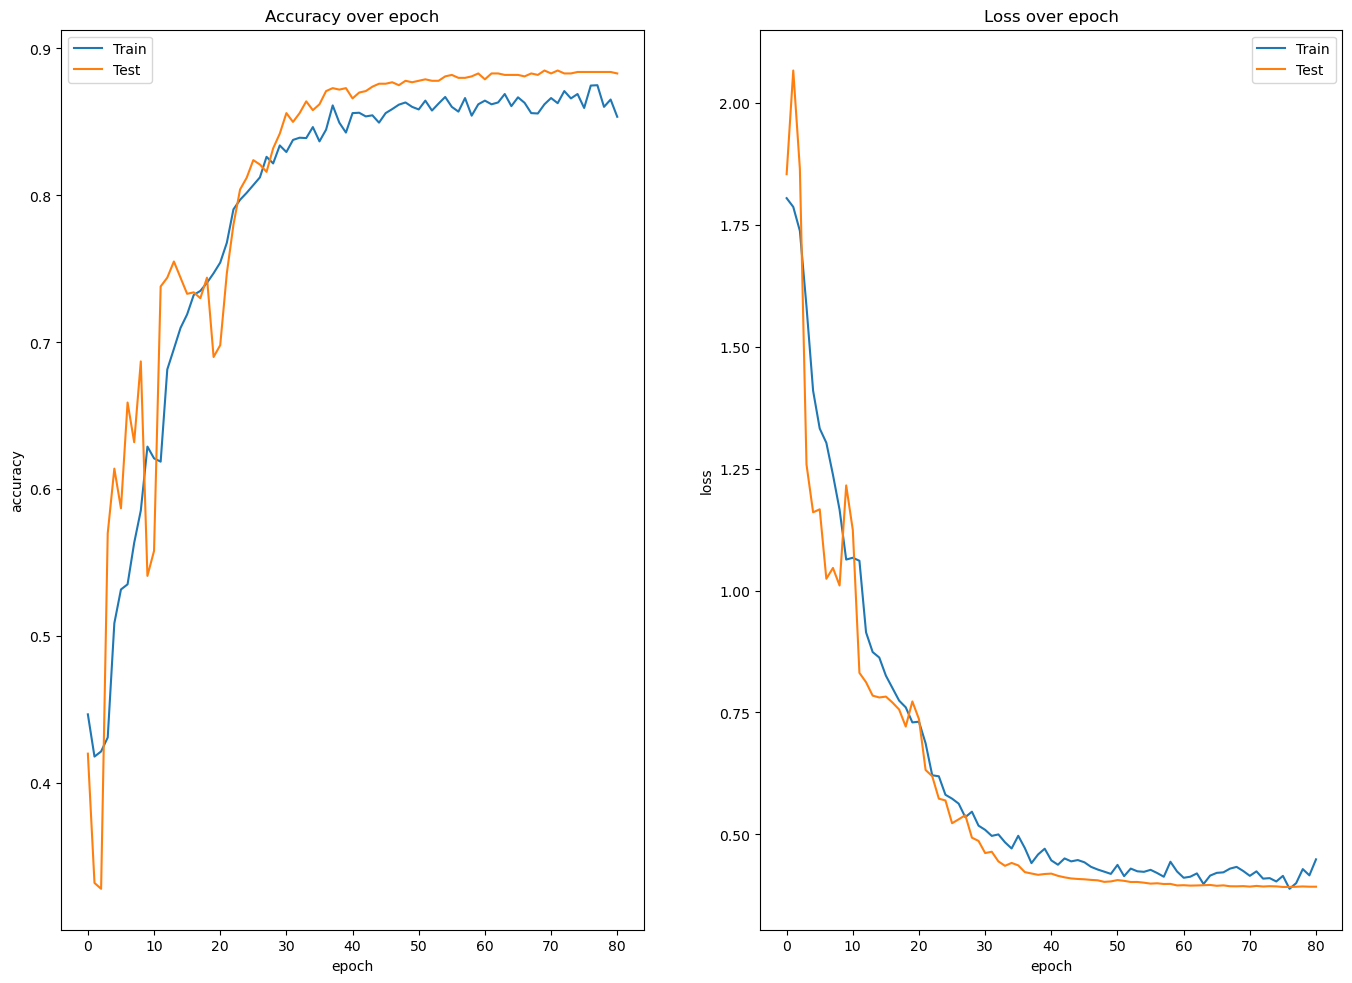

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

#### Performance del modello

- **Loss (funzione di perdita)**  
  Misura quanto le probabilità stimate dal modello si discostano dalla classe corretta.  
  Per la **sparse categorical crossentropy**:  
  $$
  \text{Loss} = \ell_i = - \frac{1}{N} \sum_{i=1}^{N} \ln \big( p_{\text{classe corretta}, i} \big)
  $$

- **Loss su un batch di $N$ esempi**  
  $$
  \text{Loss}_{\text{batch}} = \frac{1}{N} \sum_{i=1}^{N} \ell_i
  $$

- **Loss complessiva su un’epoca** (media pesata sui batch)  
  $$
  \text{Loss}_{\text{epoch}} = \frac{\sum_{b=1}^{B} N_b \cdot \text{Loss}_{\text{batch}, b}}{\sum_{b=1}^{B} N_b}
  $$

- **Accuracy (accuratezza)**  
  Percentuale di esempi classificati correttamente:  
  $$
  \text{Accuracy} = \frac{\text{numero di previsioni corrette}}{\text{numero totale di esempi}}
  $$

#### 4) Salva lo storico training (loss/acc train/val) + tempo/LR in CSV

In [66]:
history_path = os.path.join(ART_DIR, "training_history.csv")
with open(history_path, "w", newline="") as f:
    writer = csv.writer(f)
    header = ["epoch"]
    # chiavi presenti nello storico (es. loss, accuracy, val_loss, val_accuracy)
    keys = list(history.history.keys())
    header.extend(keys)
    header.extend(["epoch_time_sec", "learning_rate"])
    writer.writerow(header)

    num_epochs_real = len(history.history[keys[0]])
    for i in range(num_epochs_real):
        row = [i+1]
        for k in keys:
            row.append(history.history[k][i])
        # tempo e lr possono avere lunghezze pari alle epoche realmente eseguite
        epoch_time = time_lr_cb.epoch_times[i] if i < len(time_lr_cb.epoch_times) else ""
        lr_val     = time_lr_cb.lrs[i] if i < len(time_lr_cb.lrs) else ""
        row.extend([epoch_time, lr_val])
        writer.writerow(row)

print(f"Storico training salvato in: {history_path}")

Storico training salvato in: artifacts/training_history.csv


#### 5) Salva architettura modello (JSON) e (opzionale) pesi finali

In [67]:
model_json_path = os.path.join(ART_DIR, "model_architecture.json")
with open(model_json_path, "w") as jf:
    jf.write(model.to_json())
print(f"Architettura modello salvata in: {model_json_path}")

# I pesi "migliori" su validation sono già salvati dal ModelCheckpoint (Step 9)
# Se vuoi anche i pesi finali dell'ultima epoca, salva così:
final_weights_path = os.path.join(ART_DIR, "final.weights.h5")
model.save_weights(final_weights_path)
print(f"Pesi finali (ultima epoca) salvati in: {final_weights_path}")

Architettura modello salvata in: artifacts/model_architecture.json
Pesi finali (ultima epoca) salvati in: artifacts/final.weights.h5


#### 6) Salva scaler mean/std per banda (usati nella normalizzazione del train)

In [68]:
scaler_path = os.path.join(ART_DIR, "scaler_ms13.npz")
np.savez(scaler_path, mean=mean_per_band, std=std_per_band)
print(f"Scaler (mean/std) salvato in: {scaler_path}")

Scaler (mean/std) salvato in: artifacts/scaler_ms13.npz


#### 7) Salva le liste file effettive (train/val/test) in CSV

In [69]:
def save_file_list(csv_path, file_list):
    # file_list: lista di tuple (filepath, label)
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filepath", "label"])
        for fp, lbl in file_list:
            writer.writerow([fp, lbl])

train_csv = os.path.join(ART_DIR, "train_list.csv")
val_csv   = os.path.join(ART_DIR, "val_list.csv")
test_csv  = os.path.join(ART_DIR, "test_list.csv")

save_file_list(train_csv, train_list)
save_file_list(val_csv,   val_list)
save_file_list(test_csv,  test_list)

print(f"Liste file salvate in:\n- {train_csv}\n- {val_csv}\n- {test_csv}")

Liste file salvate in:
- artifacts/train_list.csv
- artifacts/val_list.csv
- artifacts/test_list.csv


## Step 11 — Test esterno + metriche (cosa e perché)

### Obiettivo
**Misurare davvero** come generalizza il modello su `test_ds` (mai visto).  

Mostriamo: **confusion matrix**, **precision/recall/F1** (macro/micro) e i **top-error** (le confusioni più frequenti).

- **Perché confusion matrix?** Mostra *dove* sbagliamo: righe = vero, colonne = predetto.  
- **Perché macro/micro?**  
  - **Macro** = media aritmetica tra classi (tratta ogni classe allo stesso modo).  
  - **Micro** = aggrega tutti i TP/FP/FN (pesa di più le classi con più esempi).
- **Top-error**: elenco delle coppie “vero → predetto” più frequenti, per capire gli scambi più comuni.

Le formule (richiamo):
- Accuracy:  
  $\displaystyle \text{Acc} = \frac{\sum_i \text{TP}_i}{\sum_i (\text{TP}_i + \text{FP}_i + \text{FN}_i)}$
- Precision (classe \(k\)):  
  $\displaystyle \text{Prec}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}$
- Recall (classe \(k\)):  
  $\displaystyle \text{Rec}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}$
- F1 (classe \(k\)):  
  $\displaystyle \text{F1}_k = 2 \cdot \frac{\text{Prec}_k \cdot \text{Rec}_k}{\text{Prec}_k + \text{Rec}_k}$

> Assunzioni: esistono `model`, `test_ds`, `class_names` (ordinata), `id2label`, `ART_DIR` creati negli step precedenti.

### Codice Python

In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

#### 1) Predizioni su test_ds

In [71]:
y_true, y_pred = [], []
for batch_x, batch_y in test_ds:
    probs = model.predict(batch_x, verbose=0)
    pred_ids = np.argmax(probs, axis=1)
    y_pred.extend(pred_ids.tolist())
    y_true.extend(batch_y.numpy().tolist())

y_true = np.array(y_true, dtype=np.int64)
y_pred = np.array(y_pred, dtype=np.int64)

#### 2) Accuracy grezza

In [72]:
acc = (y_true == y_pred).mean()
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8760


#### 3) Confusion matrix (righe = vero, colonne = predetto)

In [73]:
num_classes = len(class_names)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (10, 10)


#### 4) Precision/Recall/F1 (macro e micro)

In [74]:
p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

print(f"[Test] P/R/F1 micro: {p_micro:.3f}/{r_micro:.3f}/{f1_micro:.3f}")
print(f"[Test] P/R/F1 macro: {p_macro:.3f}/{r_macro:.3f}/{f1_macro:.3f}")

[Test] P/R/F1 micro: 0.876/0.876/0.876
[Test] P/R/F1 macro: 0.877/0.876/0.871


#### 5) Report per classe (testo)

In [75]:
report_txt = classification_report(
    y_true, y_pred, target_names=class_names, zero_division=0
)
print("\n=== Classification report (per classe) ===\n")
print(report_txt)


=== Classification report (per classe) ===

                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.81      0.83       200
              Forest       0.97      0.97      0.97       200
HerbaceousVegetation       0.84      0.86      0.85       200
             Highway       0.83      0.51      0.63       200
          Industrial       0.93      0.93      0.93       200
             Pasture       0.86      0.93      0.89       200
       PermanentCrop       0.75      0.89      0.81       200
         Residential       0.87      0.98      0.92       200
               River       0.88      0.92      0.90       200
             SeaLake       0.99      0.96      0.97       200

            accuracy                           0.88      2000
           macro avg       0.88      0.88      0.87      2000
        weighted avg       0.88      0.88      0.87      2000



#### 6) Salvataggi testuali

In [76]:
with open(os.path.join(ART_DIR, "test_classification_report.txt"), "w") as f:
    f.write(report_txt)
np.savetxt(os.path.join(ART_DIR, "test_confusion_matrix.csv"), cm, fmt="%d", delimiter=",")

#### 7) Heatmap confusion matrix (Matplotlib puro)

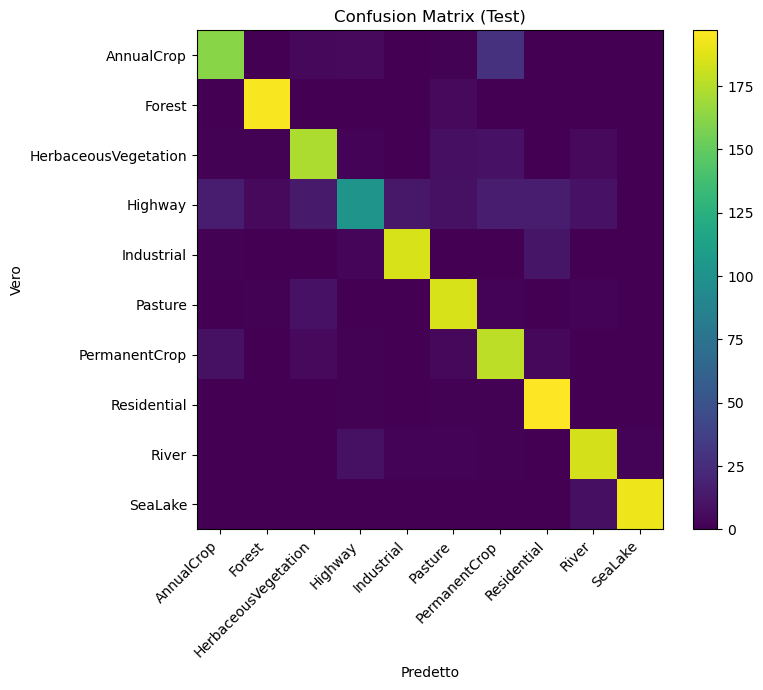

Confusion matrix salvata in: artifacts/test_confusion_matrix.png


In [77]:
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cm, interpolation="nearest", aspect="auto")  # default colormap
plt.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
ax.set_xlabel("Predetto")
ax.set_ylabel("Vero")
ax.set_title("Confusion Matrix (Test)")
plt.tight_layout()
png_path = os.path.join(ART_DIR, "test_confusion_matrix.png")
plt.savefig(png_path, dpi=150)
plt.show()
print(f"Confusion matrix salvata in: {png_path}")

In [78]:
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[162   0   4   5   0   1  28   0   0   0]
 [  0 195   0   0   0   5   0   0   0   0]
 [  1   1 173   2   0   8  10   0   5   0]
 [ 16   5  14 102  13   9  16  15  10   0]
 [  1   0   0   3 185   0   0  11   0   0]
 [  0   1  10   0   0 185   2   0   2   0]
 [  9   0   5   1   0   4 177   4   0   0]
 [  0   0   0   1   0   1   1 197   0   0]
 [  0   0   0   9   2   2   1   0 184   2]
 [  0   0   0   0   0   0   0   0   8 192]]


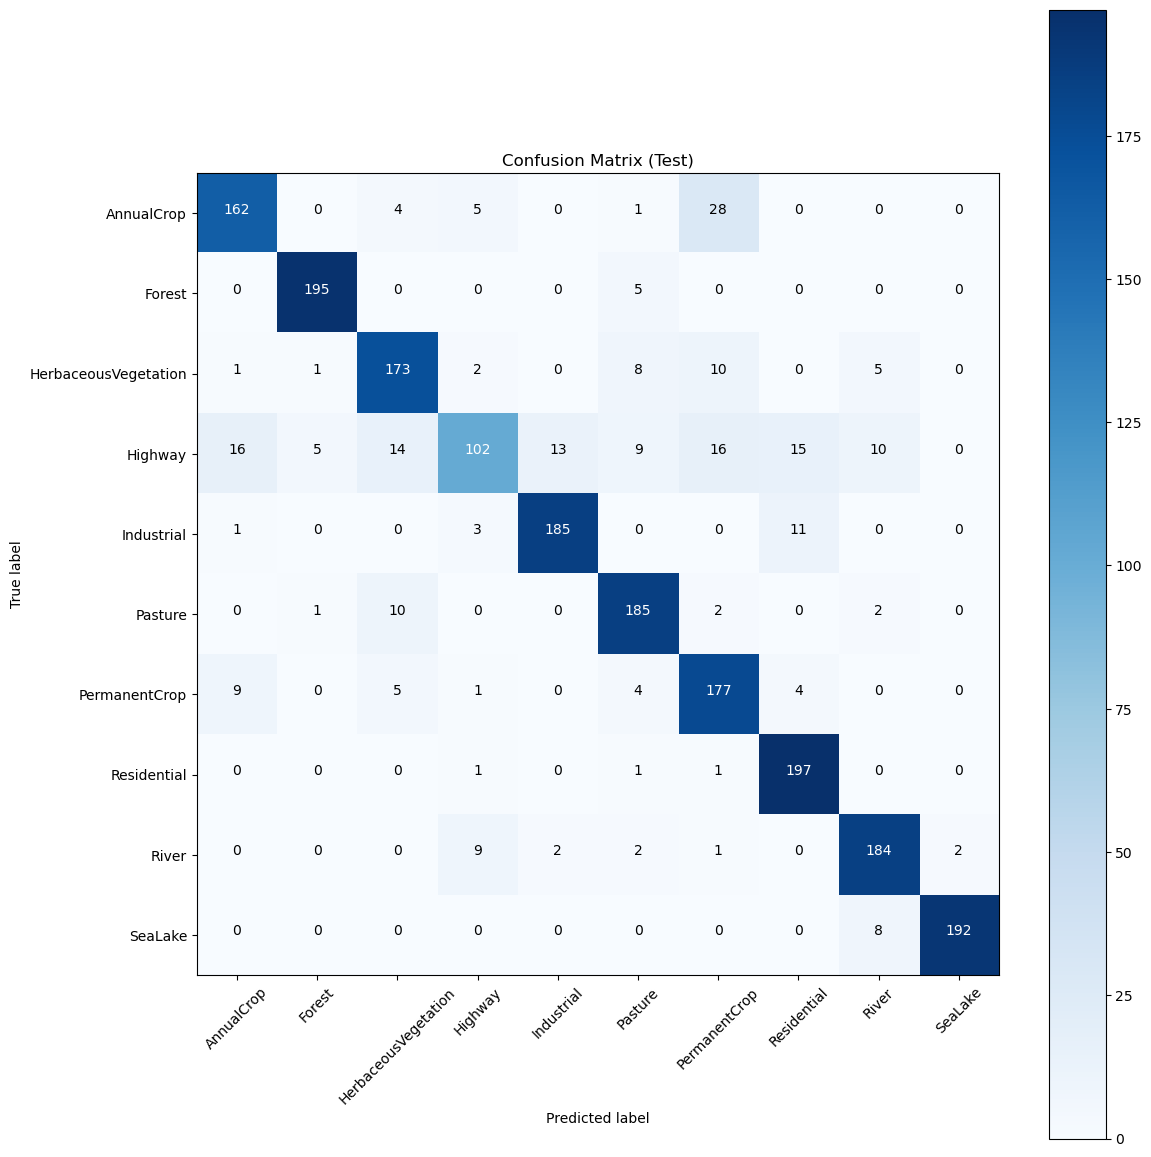

In [79]:
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title="Confusion Matrix (Test)", figsize=(12, 12))

#### 8) Top-error (coppie vero→predetto più frequenti, escludendo i corretti)

In [80]:
pairs = [(int(t), int(p)) for t, p in zip(y_true, y_pred) if t != p]
ctr = Counter(pairs)
top_n = 10
print(f"\nTop {top_n} errori (vero -> predetto) più frequenti:")
for (t, p), cnt in ctr.most_common(top_n):
    print(f"- {id2label[t]} -> {id2label[p]} : {cnt} volte")


Top 10 errori (vero -> predetto) più frequenti:
- AnnualCrop -> PermanentCrop : 28 volte
- Highway -> AnnualCrop : 16 volte
- Highway -> PermanentCrop : 16 volte
- Highway -> Residential : 15 volte
- Highway -> HerbaceousVegetation : 14 volte
- Highway -> Industrial : 13 volte
- Industrial -> Residential : 11 volte
- HerbaceousVegetation -> PermanentCrop : 10 volte
- Highway -> River : 10 volte
- Pasture -> HerbaceousVegetation : 10 volte


#### 9) (Opzionale) Normalizziamo la CM per riga (recall per classe) e salviamo

In [81]:
import pandas as pd

# Normalizzazione per riga (recall per classe)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)

# Conversione in DataFrame con etichette
cm_df = pd.DataFrame(cm_norm, index=class_names, columns=class_names)

# Salvataggio con etichette
csv_path = os.path.join(ART_DIR, "test_confusion_matrix_row_normalized.csv")
cm_df.to_csv(csv_path, float_format="%.6f")

print(f"Confusion matrix normalizzata salvata con etichette in: {csv_path}")

Confusion matrix normalizzata salvata con etichette in: artifacts/test_confusion_matrix_row_normalized.csv


#### Come leggere i risultati
- Accuracy = quota di immagini classificate correttamente sul test.
- Macro vs Micro: se c’è squilibrio tra classi, la macro racconta meglio come va su tutte le classi, non solo quelle più rappresentate.
- Confusion matrix: guarda le righe con “perdite” sulla diagonale; le colonne con più accumulo indicano classi “calamita” verso cui confluiscono gli errori.
- Top-error: elenco sintetico delle confusioni più comuni (es. Pasture → HerbaceousVegetation).

## Step 12 — Tracciabilità e riproducibilità

### Obiettivo
**Ripetere lo stesso esperimento** (stessi dati, stessi parametri, stesse versioni) e **confrontare i run** in modo pulito.

### Cosa facciamo
- Creiamo una cartella di output unica per il run: `outputs/YYYYMMDD_HHMMSS/`
- Salviamo:
  - **config** (parametri chiave: seed, K_tv/K_te, batch, lr, epochs, classi)
  - **versioni librerie** (JSON) + **requirements** (`pip freeze`)
  - **liste dati** effettive (train/val/test)
  - **scaler** (mean/std per banda)
  - **architettura** (`model_architecture.json`)
  - **pesi**: migliori (checkpoint) + finali
  - **storico training** (`training_history.csv`)
  - **metriche test** + **confusion matrix** (grezza e normalizzata)

> Nota: il codice assume che dagli step precedenti esistano le variabili:  
> `SEED, K_TV, K_TE, BATCH_SIZE, LR (learning rate), EPOCHS, class_names, label2id, id2label, train_list, val_list, test_list, mean_per_band, std_per_band, model, ART_DIR`, e i file già salvati in `artifacts/` (history, pesi, cm, report, ecc.).

### Codice Python

In [82]:
import os, json, csv, sys, platform, subprocess, datetime
import numpy as np

#### 1) Crea RUN_DIR unico

In [83]:
RUN_ROOT = "outputs"
os.makedirs(RUN_ROOT, exist_ok=True)
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(RUN_ROOT, ts)
os.makedirs(RUN_DIR, exist_ok=True)
print("RUN_DIR:", RUN_DIR)

RUN_DIR: outputs/20250908_102502


#### 2) Config esperimento (parametri chiave)

In [84]:
import numpy as np
from collections import Counter

# 1) LR effettivo dal modello (gestisce anche variabili/schedule)
try:
    lr_value = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
except Exception:
    lr_value = None  # se non estraibile

# 2) conteggi per classe dalle liste
def counts_per_class(file_list):
    return dict(Counter(lbl for _, lbl in file_list))

train_counts = counts_per_class(train_list)
val_counts   = counts_per_class(val_list)
test_counts  = counts_per_class(test_list)

# 3) train+val per classe
tv_counts = {cls: train_counts.get(cls, 0) + val_counts.get(cls, 0) for cls in class_names}

# 4) totali
n_train = sum(train_counts.values())
n_val   = sum(val_counts.values())
n_test  = sum(test_counts.values())
n_tv    = sum(tv_counts.values())

# 5) split percentuali (sul totale usato nello split)
split_total = n_tv + n_test
split = {
    "train_pct": round(100.0 * n_train / split_total, 2) if split_total else None,
    "val_pct":   round(100.0 * n_val   / split_total, 2) if split_total else None,
    "test_pct":  round(100.0 * n_test  / split_total, 2) if split_total else None,
}

In [85]:
CONFIG = {
    "seed": int(globals().get("SEED", -1)),
    "counts_per_class": {
        "train": train_counts,
        "val":   val_counts,
        "train_val": tv_counts,
        "test":  test_counts
    },
    "totals": {
        "train": n_train,
        "val":   n_val,
        "train_val": n_tv,
        "test":  n_test
    },
    "split_pct": split,                 # % effettive
    "batch_size": int(globals().get("BATCH_SIZE", -1)),
    "learning_rate_effective": lr_value,
    "epochs_max": int(globals().get("EPOCHS", -1)),
    "classes": list(class_names),
#    "label2id": label2id,
#    "id2label": id2label,
    "img_shape": [64, 64, 13],
    "notes": "EuroSAT MS (13 bande), CNN semplice 3 blocchi: Conv+BN+ReLU+Pool"
}

In [86]:
with open(os.path.join(RUN_DIR, "config.json"), "w") as f:
    json.dump(CONFIG, f, indent=2)
print("Salvato config.json")

Salvato config.json


#### 3) Versioni librerie (JSON) + pip freeze

In [87]:
def safe_ver(modname):
    try:
        mod = __import__(modname)
        return getattr(mod, "__version__", "unknown")
    except Exception:
        return "not_imported"

VERSIONS = {
    "python": sys.version.replace("\n"," "),
    "platform": platform.platform(),
    "tensorflow": safe_ver("tensorflow"),
    "numpy": safe_ver("numpy"),
    "pandas": safe_ver("pandas"),
    "scikit_learn": safe_ver("sklearn"),
    "matplotlib": safe_ver("matplotlib"),
    "tifffile": safe_ver("tifffile"),
    "rasterio": safe_ver("rasterio")
}
with open(os.path.join(RUN_DIR, "versions.json"), "w") as f:
    json.dump(VERSIONS, f, indent=2)
print("Salvato versions.json")

try:
    req = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
except Exception as e:
    req = f"# pip freeze fallito: {e}\n"
with open(os.path.join(RUN_DIR, "requirements_freeze.txt"), "w") as f:
    f.write(req)
print("Salvato requirements_freeze.txt")

Salvato versions.json
Salvato requirements_freeze.txt


#### 4) Copia/ri-salva output principali nel RUN_DIR
Se i file sono stati salvati in ART_DIR nello step 10/11, li ricopiamo qui

In [88]:
def safe_copy(src, dst_dir):
    if os.path.exists(src):
        import shutil
        shutil.copy2(src, os.path.join(dst_dir, os.path.basename(src)))
        return True
    return False

# Architettura e pesi
safe_copy(os.path.join(ART_DIR, "model_architecture.json"), RUN_DIR)
safe_copy(os.path.join(ART_DIR, "final.weights.h5"), RUN_DIR)
safe_copy("checkpoints/best.weights.h5", RUN_DIR)

# Storico training
safe_copy(os.path.join(ART_DIR, "training_history.csv"), RUN_DIR)

# Scaler (mean/std)
safe_copy(os.path.join(ART_DIR, "scaler_ms13.npz"), RUN_DIR)

# Liste file effettive
safe_copy(os.path.join(ART_DIR, "train_list.csv"), RUN_DIR)
safe_copy(os.path.join(ART_DIR, "val_list.csv"), RUN_DIR)
safe_copy(os.path.join(ART_DIR, "test_list.csv"), RUN_DIR)

# Confusion matrix e report (se già salvati allo step 11)
safe_copy(os.path.join(ART_DIR, "test_confusion_matrix.png"), RUN_DIR)
safe_copy(os.path.join(ART_DIR, "test_confusion_matrix_row_normalized.csv"), RUN_DIR)
safe_copy(os.path.join(ART_DIR, "test_confusion_matrix.csv"), RUN_DIR)  # se l’hai salvata grezza
safe_copy(os.path.join(ART_DIR, "test_classification_report.txt"), RUN_DIR)

print("Artefatti copiati nel RUN_DIR.")

Artefatti copiati nel RUN_DIR.


#### 5) Ri-salva mean/std e parametri rapidi anche come TXT leggibile

In [89]:
n_train = sum(1 for _ in train_ds.unbatch())
n_val   = sum(1 for _ in val_ds.unbatch())
n_test  = sum(1 for _ in test_ds.unbatch())

with open(os.path.join(RUN_DIR, "scaler_summary.txt"), "w") as f:
    f.write("Mean per banda (13):\n")
    f.write(", ".join([f"{v:.6f}" for v in mean_per_band.tolist()]) + "\n\n")
    f.write("Std per banda (13):\n")
    f.write(", ".join([f"{v:.6f}" for v in std_per_band.tolist()]) + "\n")

with open(os.path.join(RUN_DIR, "run_summary.txt"), "w") as f:
    f.write(f"RUN_DIR: {RUN_DIR}\n")
    f.write(f"Seed: {SEED}\n")
    f.write(f"Train: {n_train} | Val: {n_val} | Test: {n_test}\n")
    f.write(f"Batch size: {BATCH_SIZE} | LR: {CONFIG.get('learning_rate_effective', 'NA')} | Epochs: {EPOCHS}\n")
    f.write(f"Classi: {', '.join(class_names)}\n")

print("Sommari testuali salvati.")

Sommari testuali salvati.


## Step 13 – Sperimentazioni sul modello CNN custom

### A) Analisi di sensibilità e tuning del modello
- Numero di epoche: abbiamo provato 20 vs 100 → estendere.
- Dimensione del training set: aumentare immagini per classe.
- Batch size: test 32, 64, 128 → effetto su stabilità e tempo.
- Learning rate: provare 1e-2, 1e-4 oltre all’attuale 1e-3.
- Data augmentation: aggiungere rotazioni, traslazioni leggere, variazioni di luminosità.
- Profondità: testare un 4° blocco conv-pool.
- Regularization: dropout più alto, weight decay.
- Early stopping: variare la pazienza.

### B) Tracciabilità e organizzazione degli esperimenti
#### Gestione dei run
- Ogni lancio produce una cartella output/YYYYMMDD_runX/ con: modello, metriche, confusion matrix, config.
- Abbiamo già 2 run, conviene farne almeno 4–5 per confrontare iperparametri.
- Tenere un log chiaro: seme, epoche, modifiche fatte, risultati principali.